Import dependencies

In [1]:
from model.layers import GraphSpectralFilterLayer, AnalysisFilter
from model.spectral_filter import Graph
import torch
import torch.nn.functional as F
from torch import nn
from random import seed as rseed
from numpy.random import seed as nseed
from citation import get_dataset, random_planetoid_splits, run
from citation.train_eval import evaluate
import numpy as np


Define hyperparameters

In [2]:
dataset_name = 'CiteSeer'

random_splits = False
runs = 1
epochs =400
alpha = 0.7709619178612326
seed =729
lr =0.00022455151763075903
weight_decay = 7.530100210192558e-05
patience=100
hidden=32
heads =14
dropout=0.6174883141474811
normalize_features =True
pre_training = False
cuda = False
order =15
edge_dropout =0
node_feature_dropout =0
filter_name ='analysis'

rseed(seed)
nseed(seed)
torch.manual_seed(seed)

cuda = cuda and torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(seed)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
def get_correctly_predicted_node_idx(net, key, dataset):
    net.eval()
    with torch.no_grad():
        logits  = net(dataset[0])[0]
    mask = dataset[0]['{}_mask'.format(key)]
    pred = logits[mask].max(1)[1]
    return { *pred.eq(dataset[0].y[mask]).nonzero().view(-1).tolist() }

In [3]:
def matching_labels_distribution(nodes_set, G, dataset):
    hop_1_matching_percent = []
    hop_2_matching_percent = []
    hop_3_matching_percent = []
    for n in nodes_set:
        hop_1_neighbours = list(nx.ego_graph(G, n, 1).nodes())
        hop_2_neighbours = list(nx.ego_graph(G, n, 2).nodes())
        hop_3_neighbours = list(nx.ego_graph(G, n, 3).nodes())
        hop_1_neighbours.remove(n)
        hop_2_neighbours.remove(n)
        hop_3_neighbours.remove(n)
        node_label = dataset[0].y[n]
        hop_1_labels = dataset[0].y[hop_1_neighbours]
        hop_2_labels = dataset[0].y[hop_2_neighbours]
        hop_3_labels = dataset[0].y[hop_3_neighbours]
        matching_1_labels = node_label == hop_1_labels
        matching_2_labels = node_label == hop_2_labels
        matching_3_labels = node_label == hop_3_labels

        hop_1_matching_percent.append(matching_1_labels.float().sum()/max(matching_1_labels.shape[0], 1))
        hop_2_matching_percent.append(matching_2_labels.float().sum()/max(matching_2_labels.shape[0], 1))
        hop_3_matching_percent.append(matching_3_labels.float().sum()/max(matching_3_labels.shape[0], 1))


    print(torch.tensor(hop_1_matching_percent).mean())
    print('matching labels in 1st hop:', torch.tensor(hop_1_matching_percent).mean())
    print('matching labels in 2st hop:', torch.tensor(hop_2_matching_percent).mean())
    print('matching labels in 3rd hop:', torch.tensor(hop_3_matching_percent).mean())
    plt.figure(figsize=(15,3))
    plt.subplot(1, 3, 1)
    plt.hist(hop_1_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)
    plt.subplot(1, 3, 2)
    plt.hist(hop_2_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)
    plt.subplot(1, 3, 3)
    plt.hist(hop_2_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)
    return hop_1_matching_percent, hop_2_matching_percent, hop_3_matching_percent


Define model

In [4]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        data = dataset[0]
        adj = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.num_edges))
        self.G = Graph(adj)
        self.G.estimate_lmax()

        self.analysis = GraphSpectralFilterLayer(self.G, dataset.num_node_features, hidden,
                                                 dropout=dropout, out_channels=heads, filter=filter_name,
                                                 pre_training=pre_training, device='cuda' if cuda else 'cpu',
                                                 alpha=alpha, order=order)
        # self.mlp = nn.Sequential(nn.Linear(hidden * heads, 128),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(128, 64),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(64, 32),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(32, dataset.num_classes),
        #                             nn.ReLU(inplace=True))

        # self.W = torch.zeros(hidden * heads, dataset.num_classes)

        self.synthesis = GraphSpectralFilterLayer(self.G, hidden * heads, dataset.num_classes, filter=filter_name,
                                                  device='cuda' if cuda else 'cpu', dropout=dropout,
                                                  out_channels=1, alpha=alpha, pre_training=False,
                                                  order=order)

    def reset_parameters(self):
        self.analysis.reset_parameters()
        # torch.nn.init.xavier_uniform_(self.W.data, gain=1.414)
        # for layer in self.mlp:
        #     if hasattr(layer, 'reset_parameters'):
        #         layer.reset_parameters()
        self.synthesis.reset_parameters()

    def forward(self, data):
        x = data.x
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_1 = self.analysis(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_2 = self.synthesis(x)
        x = F.elu(x)
        # x = F.elu(x.mm(self.W))
        # x = self.mlp(x)
        return F.log_softmax(x, dim=1), attentions_1, attentions_2


dataset = get_dataset(dataset_name, normalize_features, edge_dropout=edge_dropout,
                                node_feature_dropout=node_feature_dropout)

if cuda:
    dataset[0].to('cuda')

# permute_masks = random_planetoid_splits if random_splits else None
# run(dataset, Net(dataset), runs, epochs, lr, weight_decay,
#     early_stopping, permute_masks)

In [5]:
class SingleNet(torch.nn.Module):
    def __init__(self, dataset):
        super(SingleNet, self).__init__()
        data = dataset[0]
        adj = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.num_edges))
        self.G = Graph(adj)
        self.G.estimate_lmax()

        self.analysis = GraphSpectralFilterLayer(self.G, dataset.num_node_features, hidden,
                                                 dropout=dropout, out_channels=heads, filter=filter_name,
                                                 pre_training=pre_training, device='cuda' if cuda else 'cpu',
                                                 alpha=alpha, order=order)

        self.W = torch.nn.Parameter(torch.zeros(hidden * heads, dataset.num_classes))

    def reset_parameters(self):
        self.analysis.reset_parameters()
        torch.nn.init.xavier_uniform_(self.W.data, gain=1.414)

    def forward(self, data):
        x = data.x
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_1 = self.analysis(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x = F.elu(x.mm(self.W))
        return F.log_softmax(x, dim=1), attentions_1, None

Load trained model and evaluate

In [6]:
model = Net(dataset)
model.load_state_dict(torch.load('./model/best_Citeseer_lt_zero.pkl'.format(dataset_name),  map_location={'cuda:0': 'cpu'}))

# model = SingleNet(dataset)
# model.load_state_dict(torch.load('./model/best_{}_single_layer.pkl'.format(dataset_name)))

filter_kernel = model.analysis.filter_kernel

model_correct_indices = get_correctly_predicted_node_idx(model, 'test', dataset)
eval_info = evaluate(model, dataset[0])
print(eval_info)

c:\users\sohey_m6zyufm\pycharmprojects\decimation_branch_mark\venv\lib\site-packages\ipykernel_launcher.py:38: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)


{'train_loss': 0.3670344054698944, 'train_acc': 0.9211822660098522, 'train_micro_f1': 0.9211822660098522, 'train_macro_f1': 0.9157023986911743, 'val_loss': 0.6948288679122925, 'val_acc': 0.796, 'val_micro_f1': 0.796, 'val_macro_f1': 0.7447925714273606, 'test_loss': 0.694846510887146, 'test_acc': 0.805, 'test_micro_f1': 0.805, 'test_macro_f1': 0.7737372300784445}


Obtain attention weights in layer 1 and 2

In [7]:
with torch.no_grad():
    _, att1, att2 = model(dataset[0])
model_att1_sum = torch.stack(att1).sum(dim=0)

In [8]:
for i in range(heads):
    print(att1[i][(att1[i].bool().float() - torch.eye(att1[i].shape[0], att1[i].shape[1])).nonzero(as_tuple=True)].mean())

tensor(0.0427)
tensor(0.0255)
tensor(1.1507e-05)
tensor(0.0012)
tensor(1.0593e-05)
tensor(nan)
tensor(7.3792e-05)
tensor(0.0561)
tensor(0.0022)
tensor(0.0561)
tensor(0.0362)
tensor(6.1590e-06)
tensor(0.0561)
tensor(0.0561)


Build NetworkX Graph

In [9]:
import networkx as nx
from scipy.sparse import coo_matrix
import numpy as np

# Build graph
adj = coo_matrix(
    (np.ones(dataset[0].num_edges),
    (dataset[0].edge_index[0].numpy(), dataset[0].edge_index[1].numpy())),
    shape=(dataset[0].num_nodes, dataset[0].num_nodes))
G = nx.Graph(adj)


In [10]:
from matplotlib import pyplot as plt
def plot_filter_banks(idx=list(range(heads)), kernel=model.analysis.filter._kernel, ax=None, no_ticks=False, legend=True):
    x = torch.linspace(0, 2, 100)
    if not ax:
        plt.figure(figsize=(10,10))
        plt.plot(x, kernel(x).detach()[:, idx])
#         if len(idx) > 1 and legend:
#             plt.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])
#         plt.show()
    else:
        ax.plot(x, kernel(x).detach()[:, idx])
#         if len(idx) > 1 and legend:
#             ax.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])
    if no_ticks:
        plt.xticks([])
        plt.yticks([])
    else:
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)


Plot filterbanks in layer 1 and 2

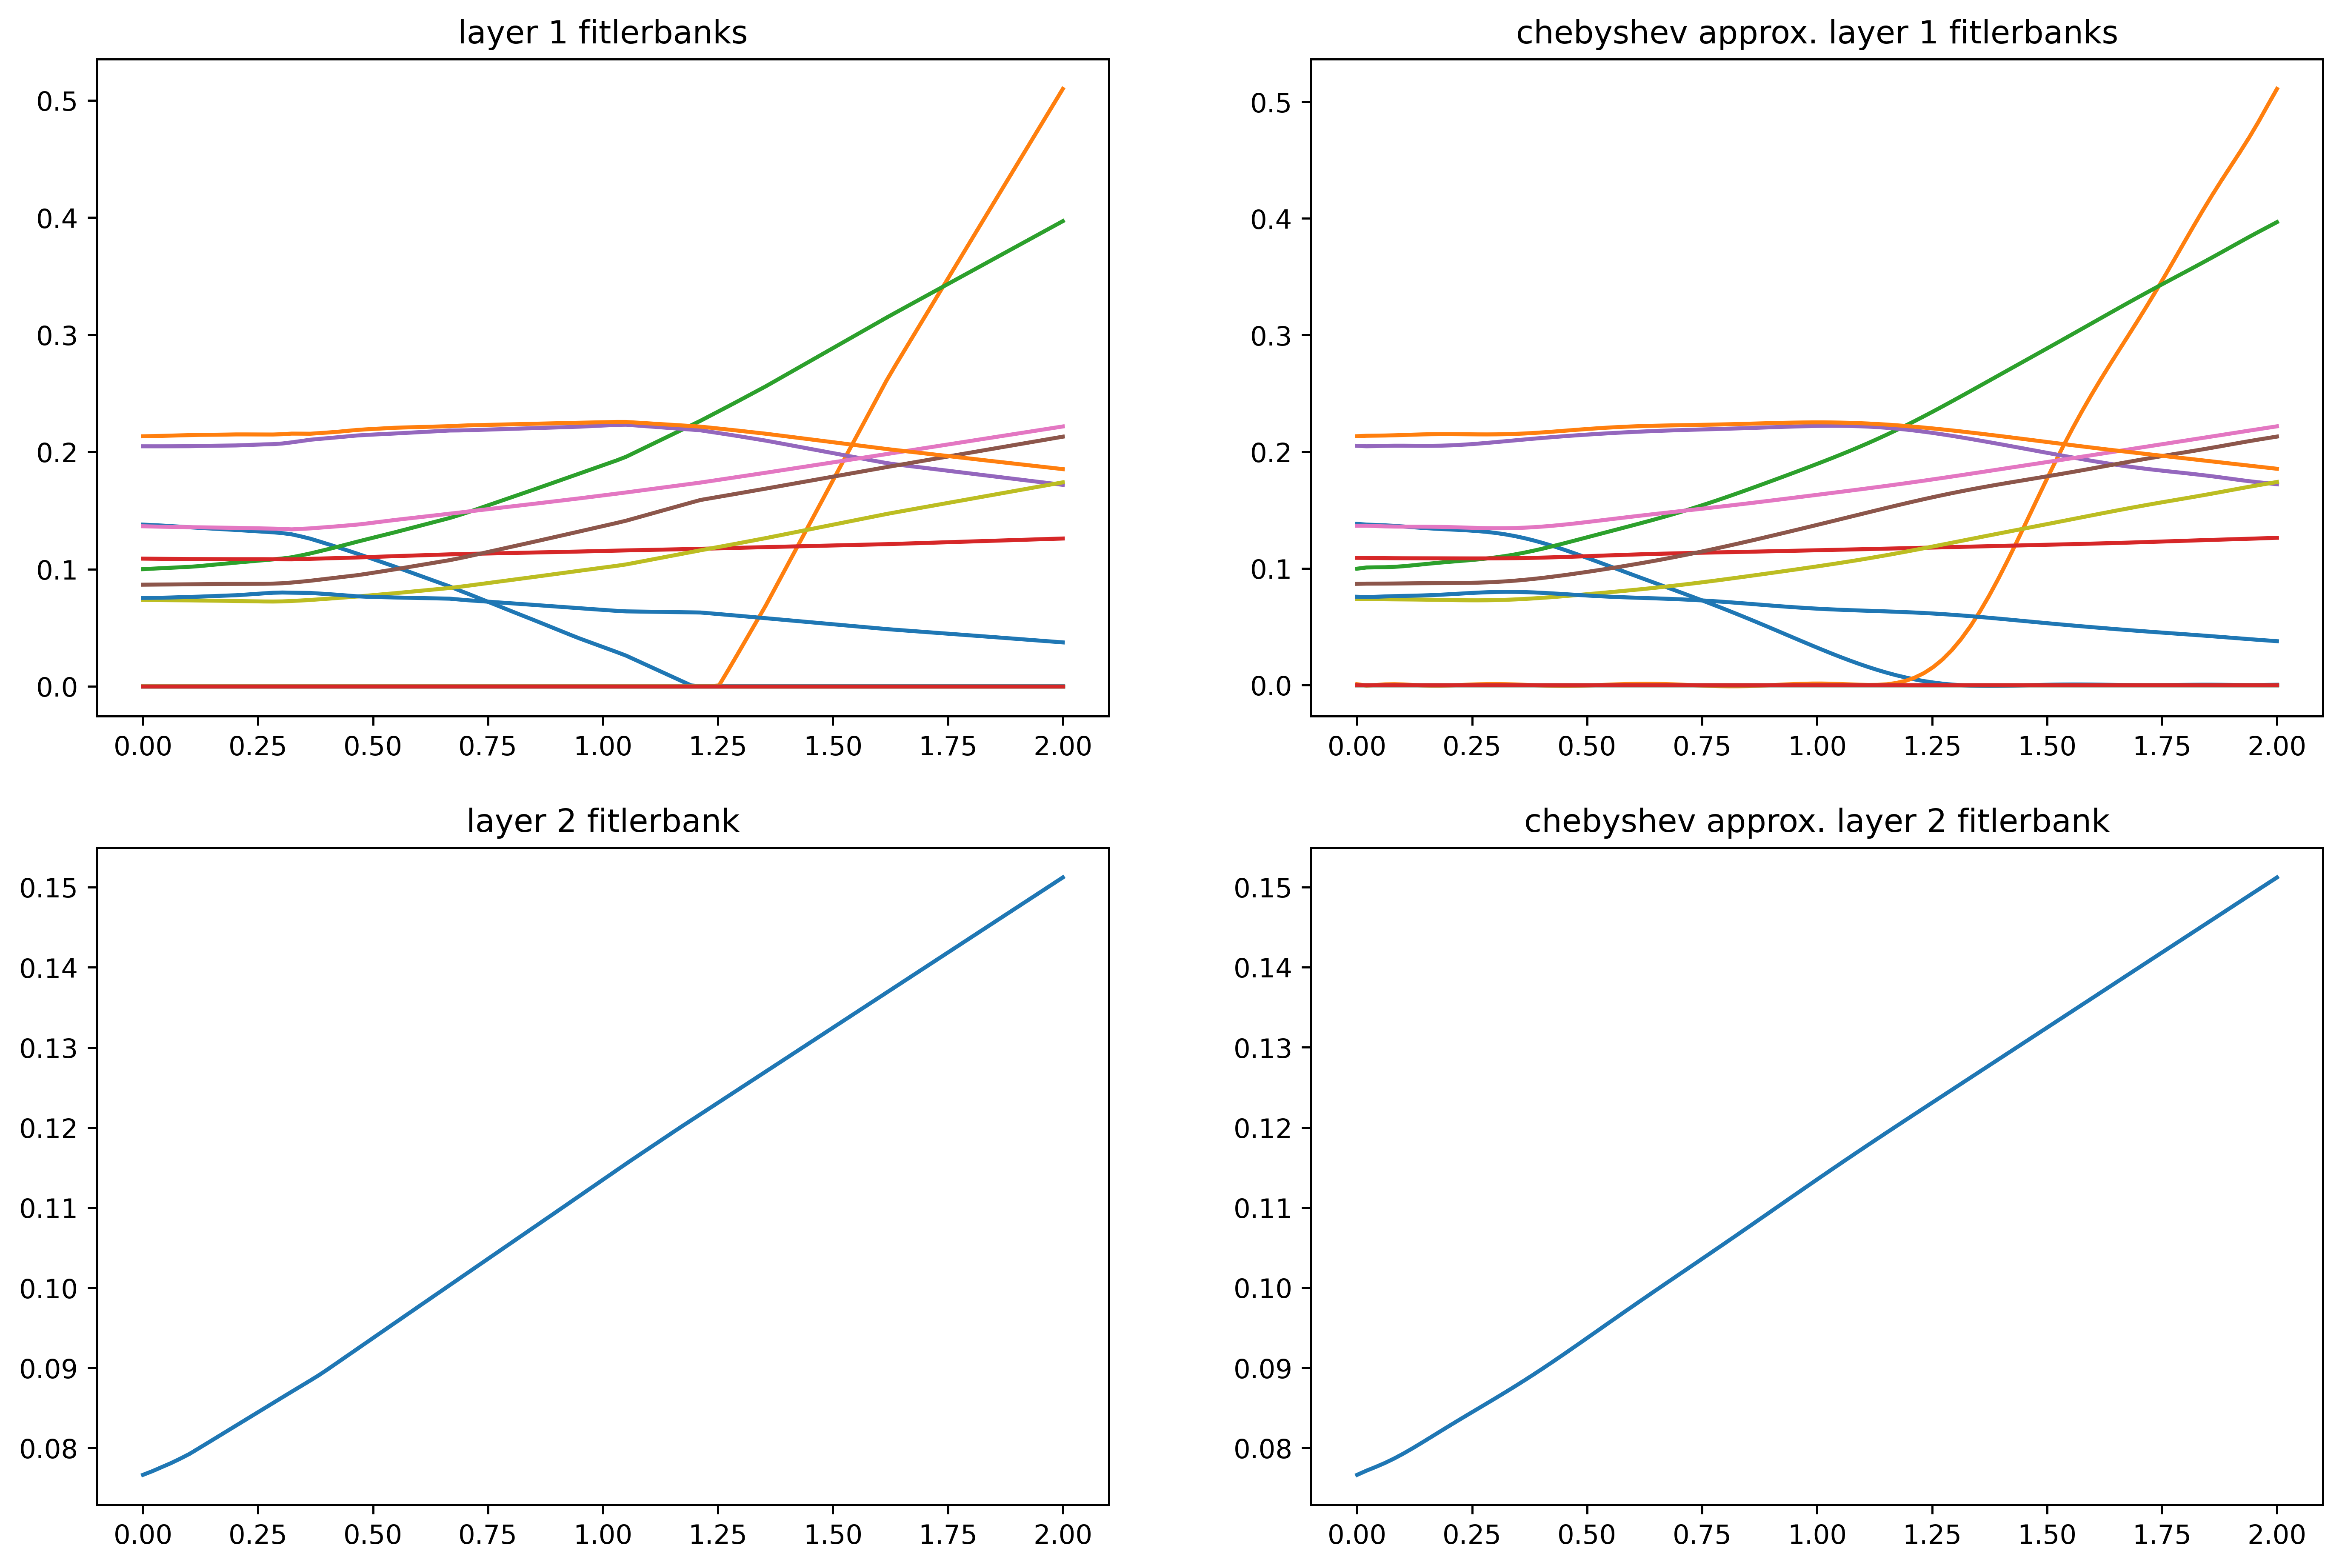

In [58]:
plt.figure(figsize=(15,10), dpi=450)
ax1 = plt.subplot(2, 2, 1)
ax1.set_title('layer 1 fitlerbanks')
plot_filter_banks(kernel=model.analysis.filter._kernel, ax=ax1)
ax2 = plt.subplot(2, 2, 2)
ax2.set_title('chebyshev approx. layer 1 fitlerbanks')
plot_filter_banks(kernel=model.analysis.filter.cheby_eval, ax=ax2)

if hasattr(model, 'synthesis'):
    ax3 = plt.subplot(2, 2, 3)
    ax3.set_title('layer 2 fitlerbank')
    plot_filter_banks(idx=[0], kernel=model.synthesis.filter._kernel, ax=ax3, legend=False)
    ax4 = plt.subplot(2, 2, 4)
    ax4.set_title('chebyshev approx. layer 2 fitlerbank')
    plot_filter_banks(idx=[0], kernel=model.synthesis.filter.cheby_eval, ax=ax4, legend=False)

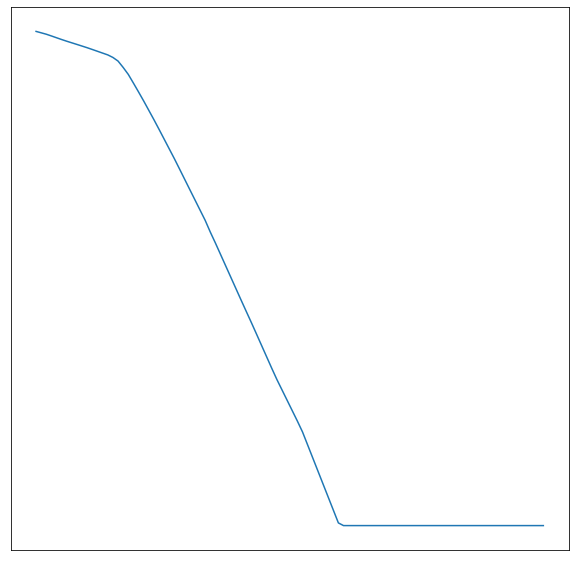

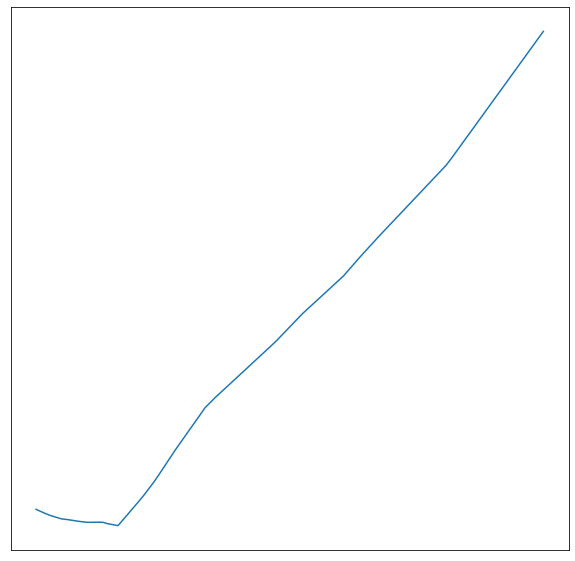

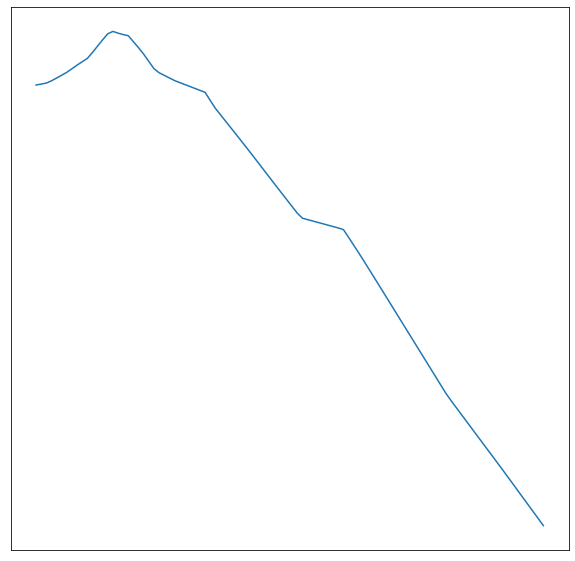

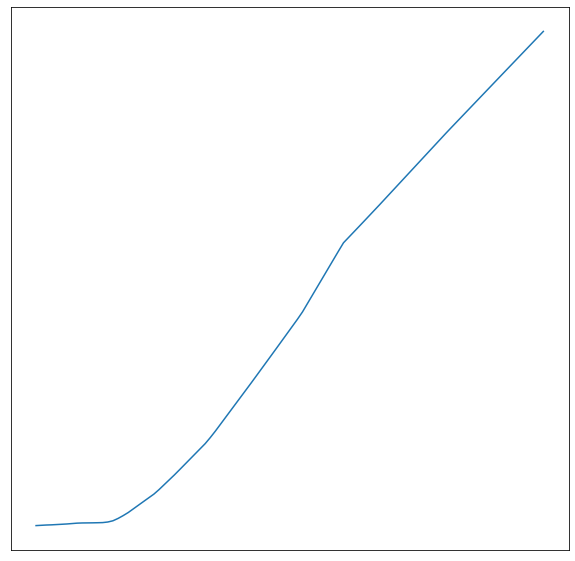

In [106]:
for i in [0, 3, 10, 5]:
    plot_filter_banks(idx=[i], kernel=model.analysis.filter._kernel, legend=False, no_ticks=True)
    plt.savefig('./node_269_filter_{}.svg'.format(str(i)), format='svg', dpi=450)

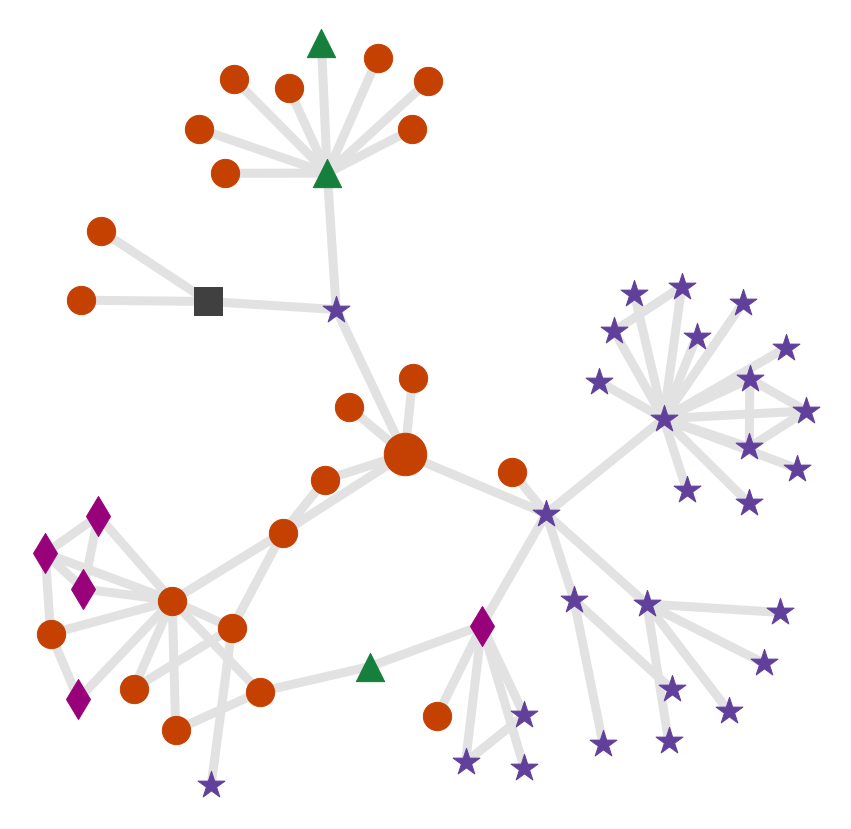

In [12]:
node = 269
# node = model_not_gat_correct_nodes[1].item()
Gego = nx.ego_graph(G, node, 3)
nodePos = nx.layout.kamada_kawai_layout(Gego)

node_colors = {
   0: plt.cm.Reds, 1: plt.cm.Oranges, 2: plt.cm.RdPu, 
   3: plt.cm.Greens, 4: plt.cm.Greys, 5: plt.cm.Purples, 
}
node_shapes={0: '8', 1: 'o', 2: 'd', 3: '^', 4: 's', 5: '*'}



plt.figure(figsize=(15,15));
# plt.figure(figsize=(15,15));                 

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.8)],
                           node_shape=node_shapes[dataset[0].y[n].item()],
                           node_size=1800 if n == node else 800,)
nx.draw_networkx_edges(Gego, nodePos,
#                            edgelist=[*[(node, n) for n in nodes], ],
                           edgelist= Gego.edges,
#                            width=[5 if e in edges else 2 for e in Gego.edges],
                           width=9,
#                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
                           edge_color=plt.cm.Greys(0.2))
plt.box(on=None)
# plt.savefig('./node_269_ego.svg', format='svg', dpi=450)
# plt.clf()
plt.show()

# for j in G.nodes:
#     a = None
#     for i in range(len(att1)):
#     #     plt.figure(figsize=(15,5), dpi=450)
# #         plt.figure(figsize=(15,5));

#         att = att1[i]
#         if a is None and len((att[j] > 0.001).nonzero().view(-1).tolist()) != 1:
#             a = len((att[j] > 0.0001).nonzero().view(-1).tolist())
#         else:
#             if a is not None and np.abs(a - len((att[j] > 0.001).nonzero().view(-1).tolist())) > 3 and len((att[j] > 0.001).nonzero().view(-1).tolist()) != 1:
#                 if nx.single_source_shortest_path_length(G, j) > 1:
#                     print(j)
#                     print(i, a, len((att[j] > 0.001).nonzero().view(-1).tolist()))


In [37]:
Gego.nodes

NodeView((1, 2180, 1542, 2567, 2568, 906, 1804, 269, 784, 3220, 1429, 2458, 2459, 3228, 2460, 1822, 2461, 33, 3234, 3235, 3236, 1570, 3107, 2222, 1202, 1587, 2356, 54, 441, 2493, 3006, 2812, 2501, 2558, 3271, 1097, 2378, 2891, 1742, 1362, 979, 1363, 728, 1115, 604, 988, 3042, 486, 746, 1772, 1903, 2420, 244, 1782, 249, 3194, 508, 509, 254))

In [105]:

node=269
# # node=4
# # node = model_not_gat_correct_nodes[1].item()
# Gego = nx.ego_graph(G, node, 3)
# nodePos = nx.layout.kamada_kawai_layout(Gego)
# node_colors = {
#    0: plt.cm.Reds, 1: plt.cm.Oranges, 2: plt.cm.RdPu, 
#    3: plt.cm.Greens, 4: plt.cm.Greys, 5: plt.cm.Purples, 
# }
# node_shapes={0: '8', 1: 'o', 2: 'd', 3: '^', 4: 's', 5: '*'}



# for n in Gego.nodes:
#     nx.draw_networkx_nodes(Gego, nodePos,
#                            nodelist=[n],
#                            node_color=[node_colors[dataset[0].y[n].item()](0.8)],
#                            node_shape="*" if n == node else node_shapes[dataset[0].y[n].item()],
#                            node_size=350 if n == node else 80)
# nx.draw_networkx_edges(Gego,nodePos, width=2, alpha=0.4)
# for i in range(heads):
# for i in [0, 3, 5, 10]:
for i in [0]:
    plt.figure(figsize=(10,10))
    plt.box(on=None)
    att = att1[i]
    nodes = (att[node] > 0.0).nonzero().view(-1).tolist()
    print(i, len(nodes))
#     plt.figure(figsize=(15,5), dpi=450);
#     ax = plt.subplot(1, 2, 1)
#     plot_filter_banks(idx=[i], ax=ax, no_ticks=True)

#     ax = plt.subplot(1, 2, 2)
    for n in Gego.nodes:
#     for n in nodes:
        nx.draw_networkx_nodes(Gego, nodePos,
                               nodelist=[n],
                               node_color=[node_colors[dataset[0].y[n].item()](0.7)],
                               node_shape=node_shapes[dataset[0].y[n].item()],
                               node_size=(att1[i][node, n]*8000).clamp(max=1000).item(),
                               alpha=1 if n in nodes else 0.2
#                                node_size=300 if n == node else (torch.exp(att[node, n])*100).clamp(max=300, min=50),
#                                node_size=300 if n == node else 200
                              )
    
    edges = list(filter(lambda e: e[0] in nodes and e[1] in nodes, list(Gego.edges)))
#     nx.draw_networkx_edges(Gego, nodePos,
# #                            edgelist=[*[(node, n) for n in nodes], ],
#                            edgelist= Gego.edges,
# #                            width=[5 if e in edges else 2 for e in Gego.edges],
#                            width=7,
# #                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
#                            edge_color=plt.cm.Greys(0.2),
#                            alpha=0.3)
#     nx.draw_networkx_edges(Gego, nodePos,
#                            edgelist=[*[(n, node) for n in nodes], ],
# #                            edgelist= Gego.edges,
# #                            width=[5 if e in edges else 2 for e in Gego.edges],
#                            width=4,
#                            style="dashed",
# #                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
# #                            alpha=0.5,
#                            edge_color=plt.cm.Greys(0.4),
#                            arrows=True)
    Gego = nx.DiGraph(Gego)
    nx.draw_networkx_edges(Gego, nodePos,
                           edgelist=[*[(n, node) for n in nodes], ],
#                            edgelist= Gego.edges,
#                            width=[5 if e in edges else 2 for e in Gego.edges],
                           width=7,
#                            edge_color=[plt.cm.Greys(0.8) if e in edges else plt.cm.Greys(0.2) for e in Gego.edges],
                           alpha=0.6,
                           arrowsize=36,
                           arrowstyle='->',
                           edge_color=plt.cm.Blues(0.8),
                           connectionstyle='arc3,rad=0.1',
                           arrows=True)
#     plt.show()
    plt.savefig('./node_269_ego_{}.svg'.format(str(i)), format='svg', dpi=450)
    plt.clf()


0 16


<Figure size 720x720 with 0 Axes>

### Frequency cutoff analysis

In [107]:
# Cut frequency bands abruptly
class CutOff(nn.Module):
    def __init__(self, kernel, min_val = 0, max_val = 2):
        super(CutOff, self).__init__()
        self.min = min_val
        self.max = max_val
        self.kernel = kernel

    def reset_parameters(self):
        pass

    def forward(self, x):
        h = torch.where(x.view(-1,1).repeat(1, heads) < self.min, torch.zeros(x.shape[0], heads), self.kernel(x))
        h = torch.where(x.view(-1,1).repeat(1, heads) > self.max, torch.zeros(x.shape[0], heads), h)
        return h

Evaluate low pass cutoff

{'train_loss': 0.43900343775749207, 'train_acc': 0.8697318007662835, 'train_micro_f1': 0.8697318007662835, 'train_macro_f1': 0.8567674570821513, 'val_loss': 0.6779998540878296, 'val_acc': 0.796, 'val_micro_f1': 0.796, 'val_macro_f1': 0.7384375342773138, 'test_loss': 0.6835559010505676, 'test_acc': 0.801, 'test_micro_f1': 0.801, 'test_macro_f1': 0.7659374314224672}


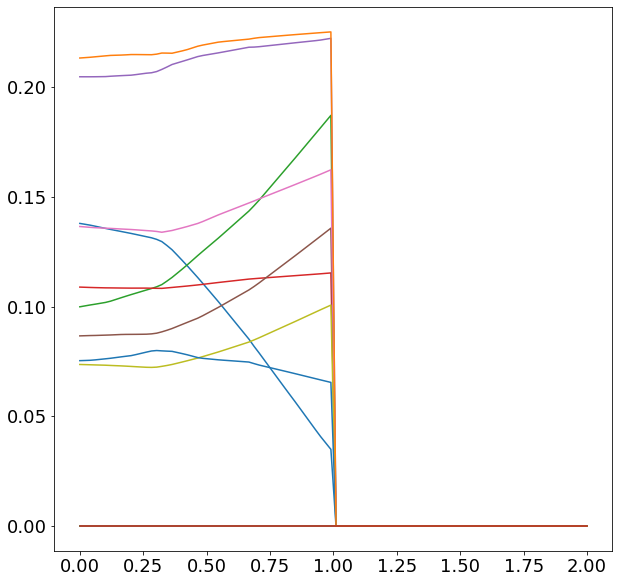

In [108]:
threshold = 1
model.analysis.filter_kernel = CutOff(max_val=threshold, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(max_val=threshold, kernel=filter_kernel)
plot_filter_banks(kernel=model.analysis.filter_kernel)
print(evaluate(model, dataset[0]))

low_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test', dataset)
with torch.no_grad():
    _, low_att1, low_att2 = model(dataset[0])

{'train_loss': 0.4115479588508606, 'train_acc': 0.9113300492610837, 'train_micro_f1': 0.9113300492610837, 'train_macro_f1': 0.905521972660433, 'val_loss': 0.7065767049789429, 'val_acc': 0.792, 'val_micro_f1': 0.792, 'val_macro_f1': 0.7341507580504952, 'test_loss': 0.7032492756843567, 'test_acc': 0.809, 'test_micro_f1': 0.809, 'test_macro_f1': 0.7770642080628062}


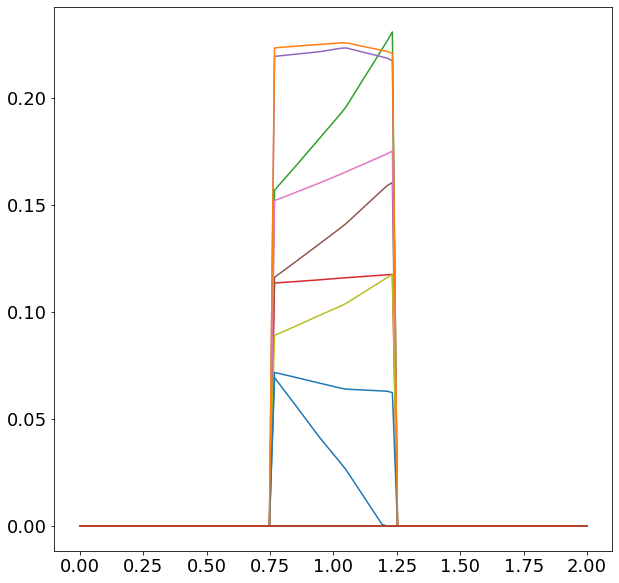

In [109]:
min_threshold = 0.75
max_threshold = 1.25
model.analysis.filter_kernel = CutOff(max_val=max_threshold, min_val=min_threshold, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(max_val=max_threshold, min_val=min_threshold, kernel=filter_kernel)
plot_filter_banks(kernel=model.analysis.filter_kernel)
print(evaluate(model, dataset[0]))

mid_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test', dataset)
with torch.no_grad():
    _, low_att1, low_att2 = model(dataset[0])

Evaluate high pass cutoff

{'train_loss': 0.891304075717926, 'train_acc': 0.8620689655172413, 'train_micro_f1': 0.8620689655172413, 'train_macro_f1': 0.8471230277041276, 'val_loss': 1.0047401189804077, 'val_acc': 0.778, 'val_micro_f1': 0.778, 'val_macro_f1': 0.7196785319665162, 'test_loss': 1.0180137157440186, 'test_acc': 0.795, 'test_micro_f1': 0.795, 'test_macro_f1': 0.7593801914911311}


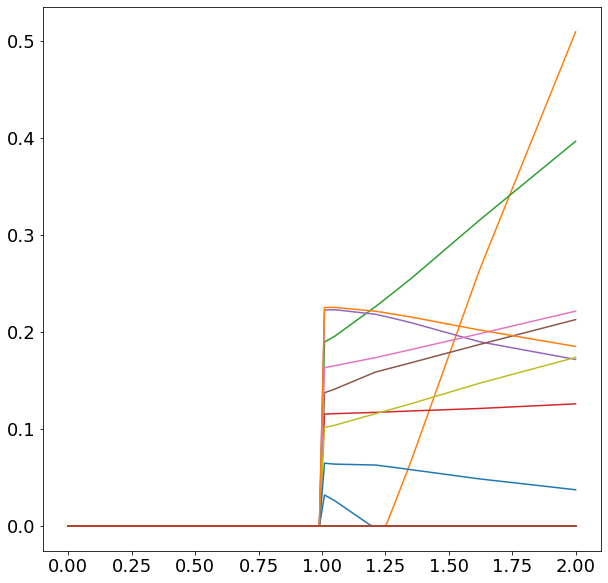

In [110]:

threshold = 1
model.analysis.filter_kernel = CutOff(min_val=threshold, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(min_val=threshold, kernel=filter_kernel)
plot_filter_banks(kernel=model.analysis.filter_kernel)
print(evaluate(model, dataset[0]))

high_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test', dataset)

with torch.no_grad():
    _, high_att1, high_att2 = model(dataset[0])

Evaluate band pass cutoff

[0.801, 0.795]


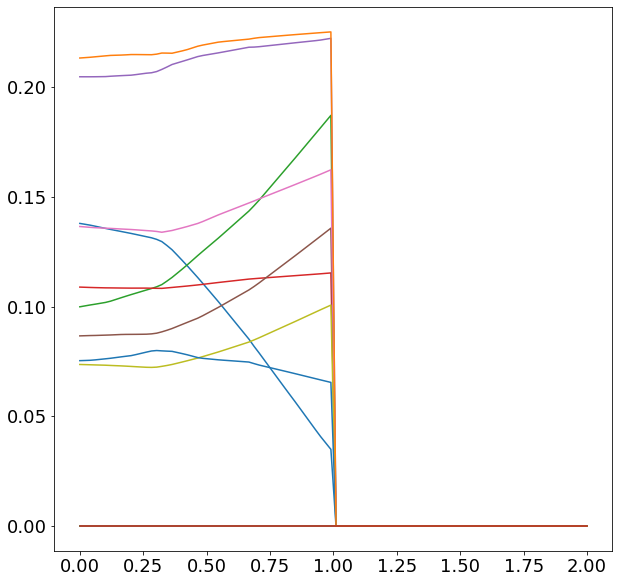

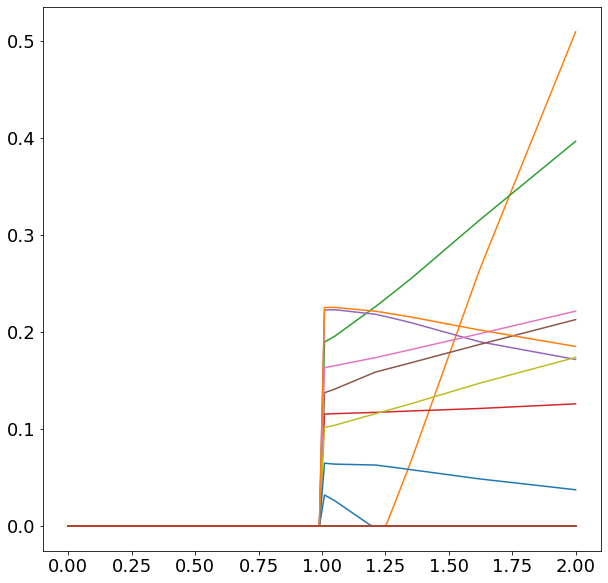

In [111]:
step = 1
acc = []
for threshold in torch.arange(0, 1.76, 1):
    model.analysis.filter_kernel = CutOff(min_val=threshold, max_val=threshold+step, kernel=filter_kernel)
    model.analysis.filter._kernel = CutOff(min_val=threshold,max_val=threshold+step, kernel=filter_kernel)
    
    plot_filter_banks(kernel=model.analysis.filter_kernel)
#     plot_filter_banks(kernel=model.analysis.filter.cheby_eval)
    eval_info = evaluate(model, dataset[0])
    acc.append(eval_info['test_acc'])
print(acc)
    

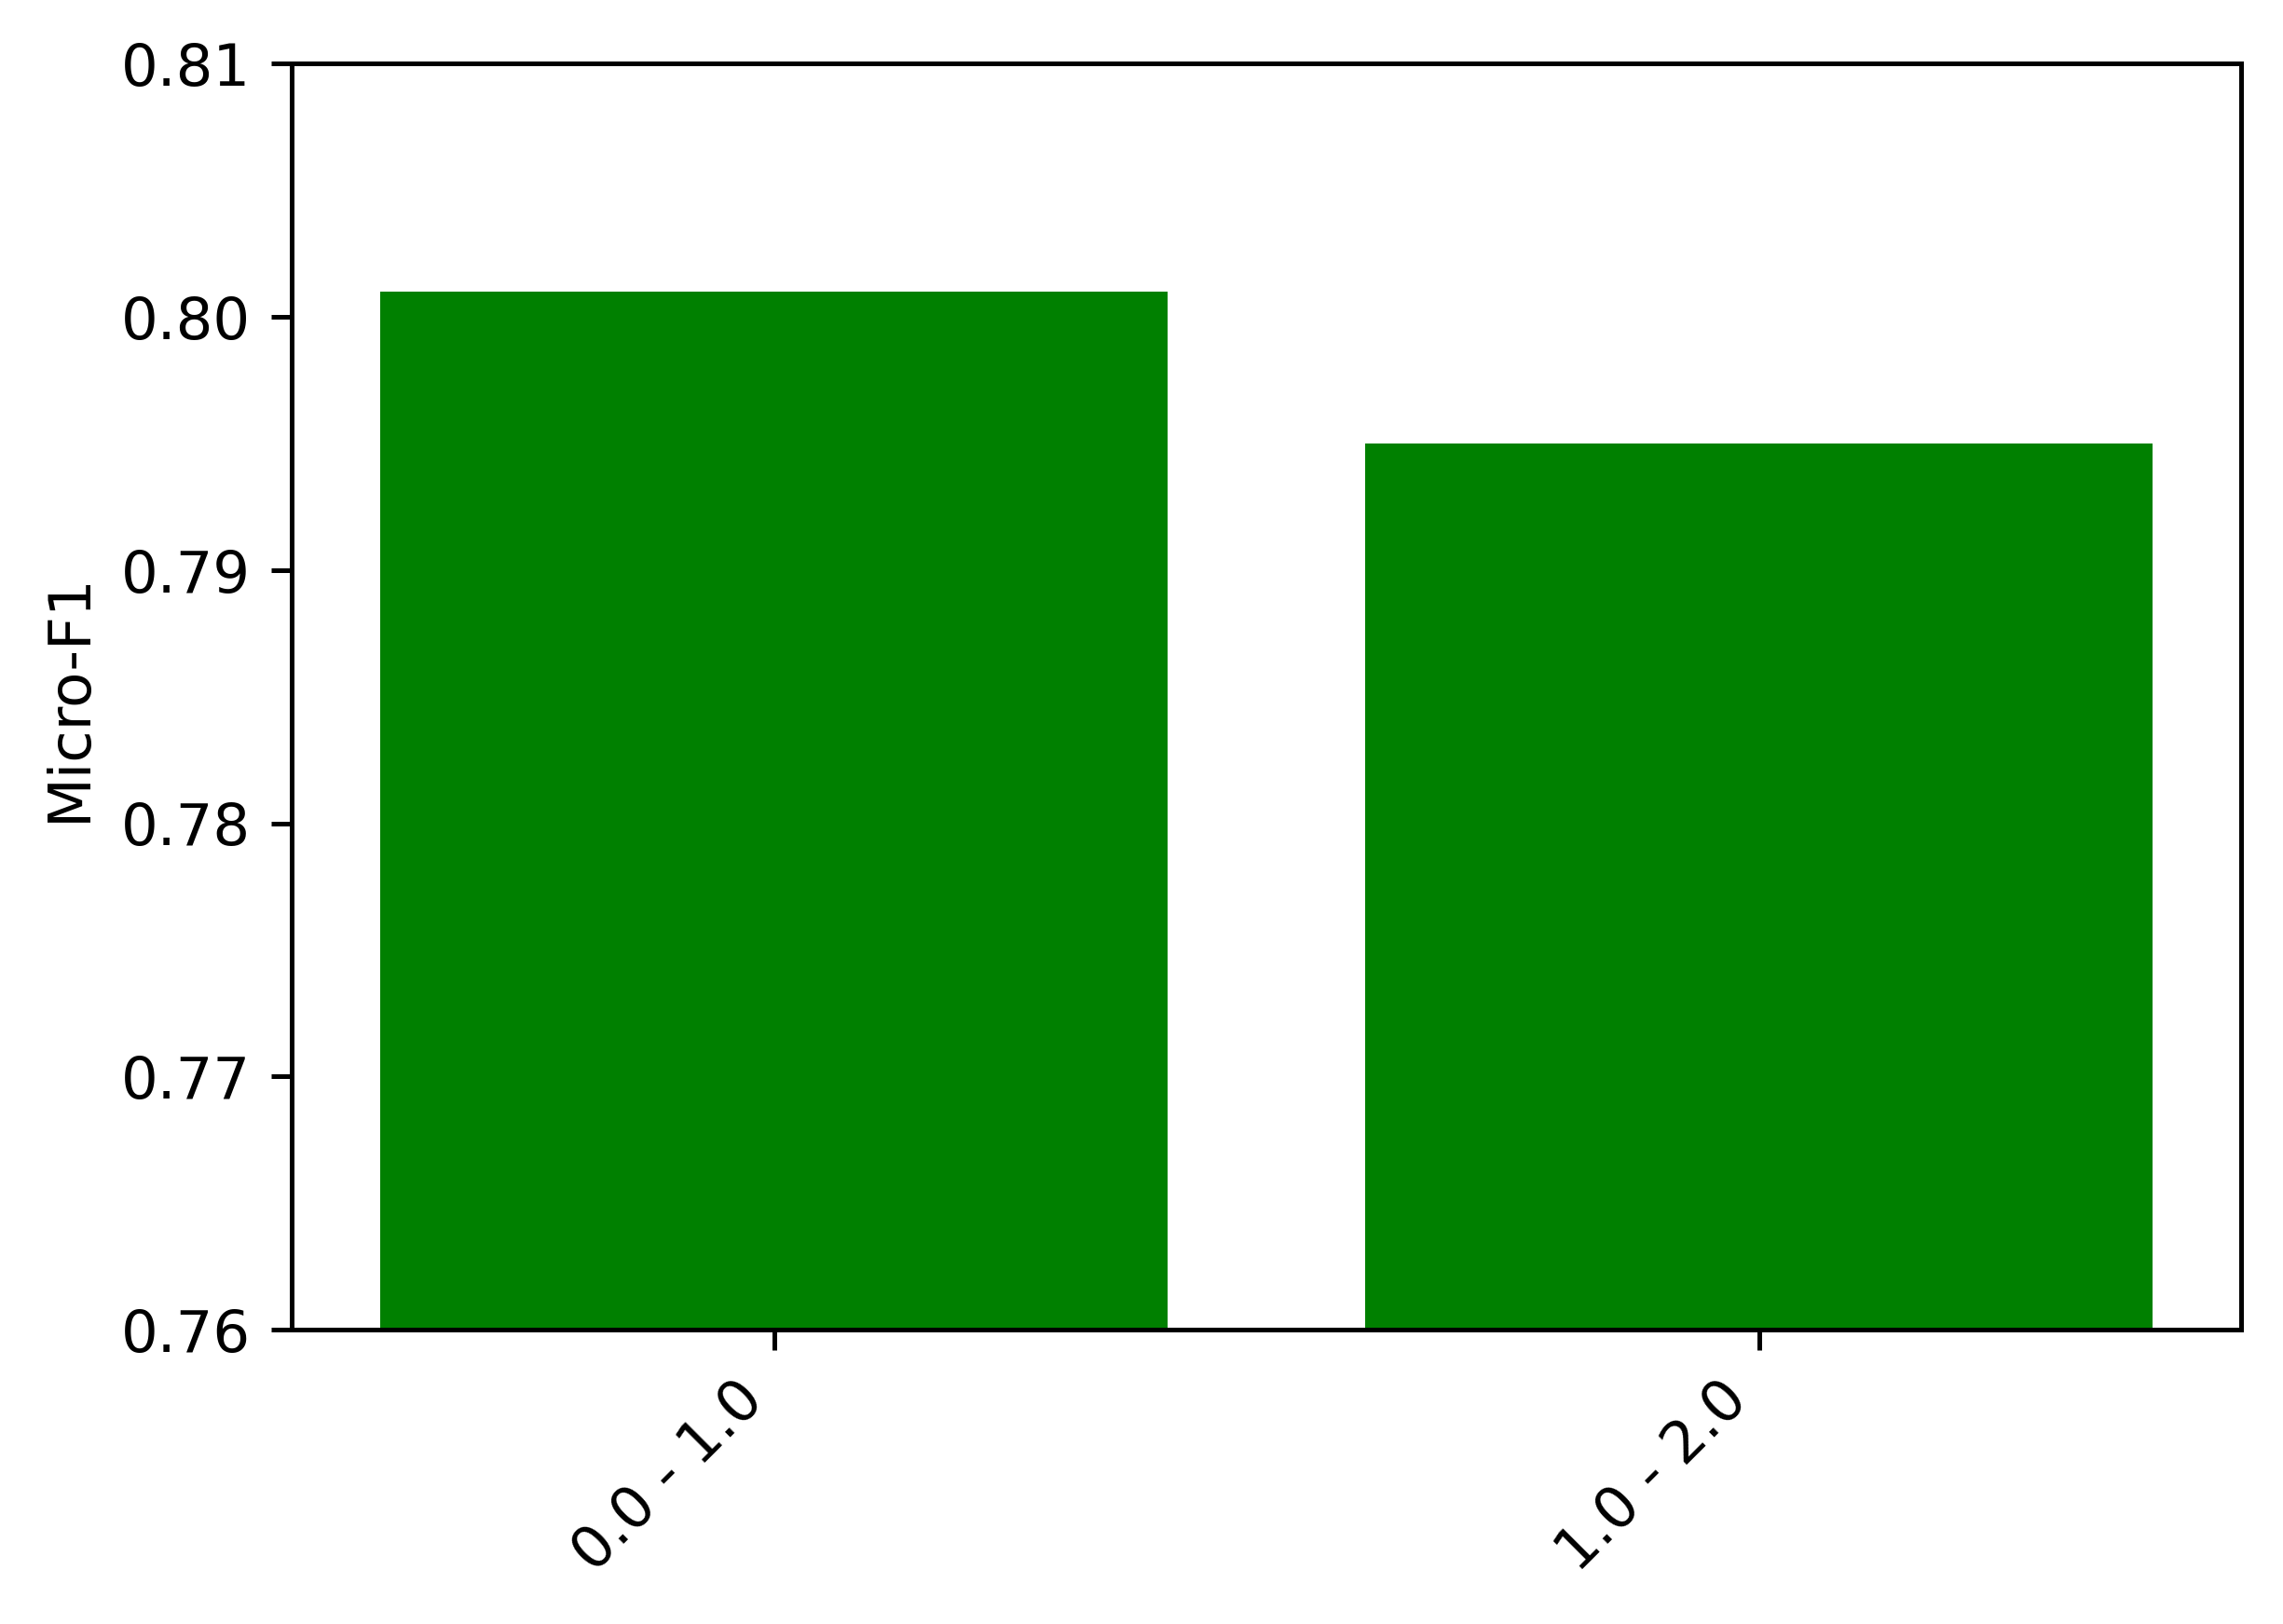

In [112]:
x = torch.arange(0, 1.76, 1)

x = ['{} - {}'.format(f.item(), f.item()+1) for f in x]

x_pos = [i for i, _ in enumerate(x)]

plt.figure(dpi=450)
plt.bar(x_pos, acc, color='green')
plt.ylabel("Micro-F1")

plt.xticks(x_pos, x)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylim(0.76, 0.81)


plt.show()

{'train_loss': 0.5665571689605713, 'train_acc': 0.8166392993979201, 'train_micro_f1': 0.8166392993979201, 'train_macro_f1': 0.795342253328798, 'val_loss': 0.7179193496704102, 'val_acc': 0.776, 'val_micro_f1': 0.776, 'val_macro_f1': 0.7176899025538349, 'test_loss': 0.7270241379737854, 'test_acc': 0.786, 'test_micro_f1': 0.786, 'test_macro_f1': 0.7469471011831037}


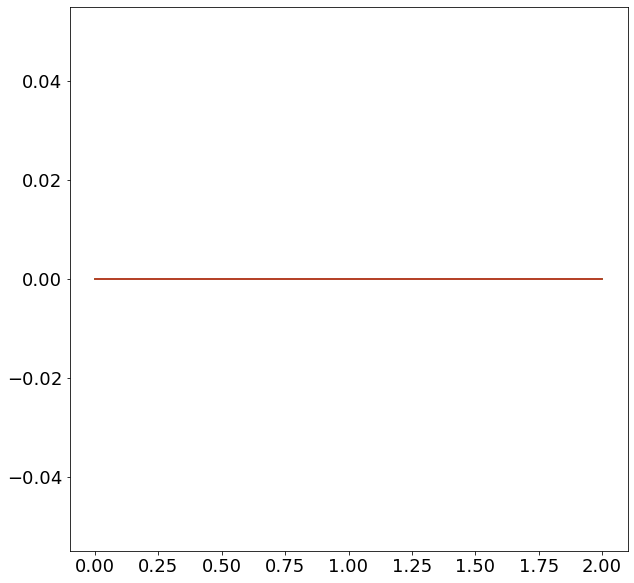

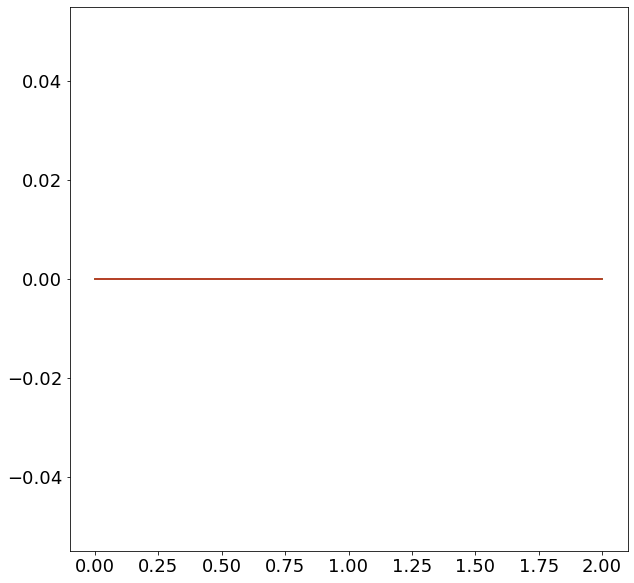

In [113]:
model.analysis.filter_kernel = CutOff(min_val=2, max_val=0, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(min_val=2, max_val=0, kernel=filter_kernel)

plot_filter_banks(kernel=model.analysis.filter_kernel)
plot_filter_banks(kernel=model.analysis.filter.cheby_eval)
print(evaluate(model, dataset[0]))

#### Frequency analysis on cutoff

In [117]:
low_not_high_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(low_pass_correct_indices.difference(high_pass_correct_indices))]
high_not_low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices.difference(low_pass_correct_indices))]
high_and_low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices.intersection(low_pass_correct_indices))]
low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(low_pass_correct_indices)]
high_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices)]
mid_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(mid_pass_correct_indices)]


print('Number of node classified correctly by low-pass filters:', len(low_correct_nodes))
print('Number of node classified correctly by high-pass filters:', len(high_correct_nodes))
print('Number of node classified correctly by mid-pass filters:', len(mid_correct_nodes))
print('Number of node classified correctly by low-pass filters but not by high-pass filters:', len(low_not_high_correct_nodes))
print('Number of node classified correctly by high-pass filters but not by low-pass filters:', len(high_not_low_correct_nodes))
print('Number of node classified correctly by both high-pass and low-pass filters:', len(high_and_low_correct_nodes))

Number of node classified correctly by low-pass filters: 801
Number of node classified correctly by high-pass filters: 795
Number of node classified correctly by mid-pass filters: 809
Number of node classified correctly by low-pass filters but not by high-pass filters: 24
Number of node classified correctly by high-pass filters but not by low-pass filters: 18
Number of node classified correctly by both high-pass and low-pass filters: 777


Neighbour distribution of nodes classified correct by high-pass

tensor(0.7072)
matching labels in 1st hop: tensor(0.7072)
matching labels in 2st hop: tensor(0.6844)
matching labels in 3rd hop: tensor(0.6519)


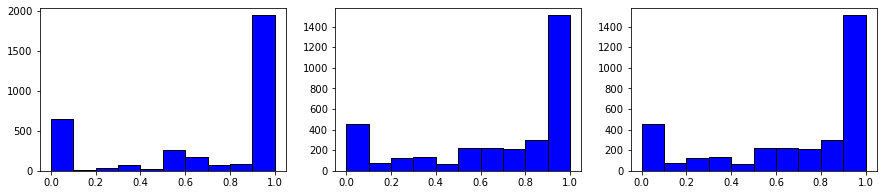

In [144]:
matching_labels_distribution(list(G.nodes), G, dataset);

tensor(0.8495)
matching labels in 1st hop: tensor(0.8495)
matching labels in 2st hop: tensor(0.8176)
matching labels in 3rd hop: tensor(0.7778)


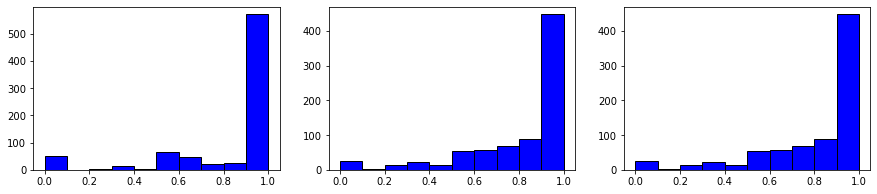

In [143]:
matching_labels_distribution(high_correct_nodes.tolist(), G, dataset);

Neighbour distribution of nodes classified correct by low-pass

tensor(0.8513)
matching labels in 1st hop: tensor(0.8513)
matching labels in 2st hop: tensor(0.8160)
matching labels in 3rd hop: tensor(0.7763)


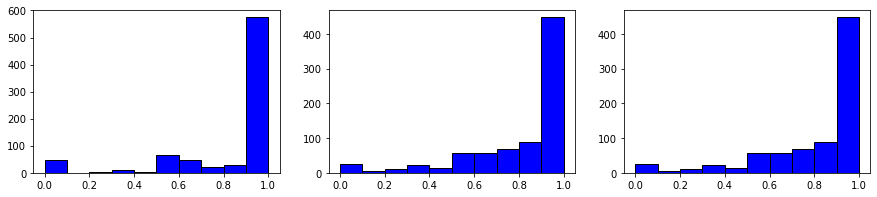

In [145]:
matching_labels_distribution(low_correct_nodes.tolist(), G, dataset);

Neighbour distribution of nodes classified correct by high-pass but not low pass

tensor(0.3039)
matching labels in 1st hop: tensor(0.3039)
matching labels in 2st hop: tensor(0.2908)
matching labels in 3rd hop: tensor(0.2548)


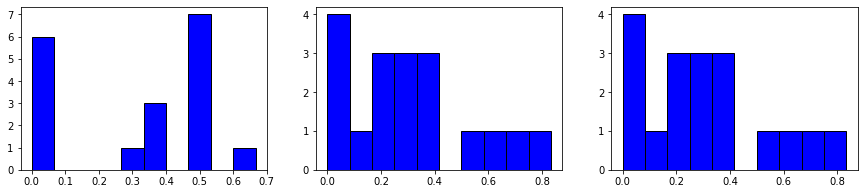

In [146]:
matching_labels_distribution(high_not_low_correct_nodes.tolist(), G, dataset);

tensor(0.4999)
matching labels in 1st hop: tensor(0.4999)
matching labels in 2st hop: tensor(0.3685)
matching labels in 3rd hop: tensor(0.3372)


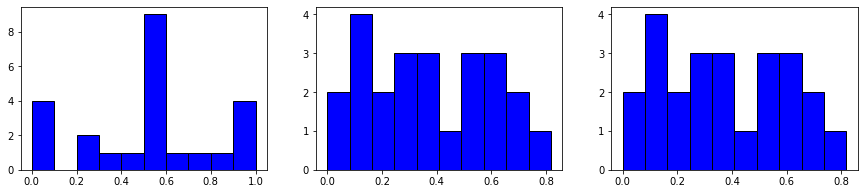

In [148]:
matching_labels_distribution(low_not_high_correct_nodes.tolist(), G, dataset);

tensor(0.8622)
matching labels in 1st hop: tensor(0.8622)
matching labels in 2st hop: tensor(0.8298)
matching labels in 3rd hop: tensor(0.7899)


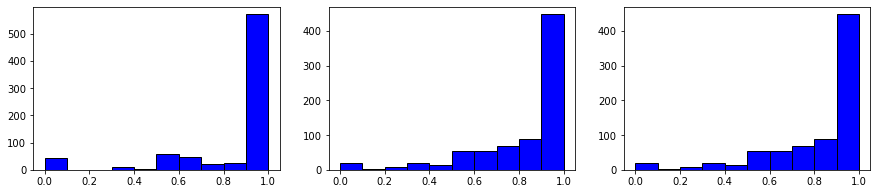

In [149]:
matching_labels_distribution(high_and_low_correct_nodes.tolist(), G, dataset);

Accuracy on less-similar neighbourhoods

tensor(0.7274)
matching labels in 1st hop: tensor(0.7274)
matching labels in 2st hop: tensor(0.6952)
matching labels in 3rd hop: tensor(0.6611)


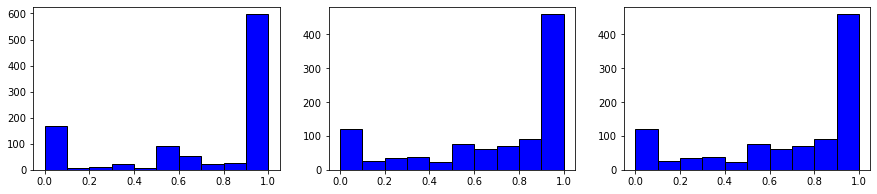

In [21]:
from matplotlib import pyplot as plt
label_distributions = matching_labels_distribution(dataset[0]['test_mask'].nonzero().view(-1).tolist(), G, dataset);

Draw attentions from high-pass filterbank(s)

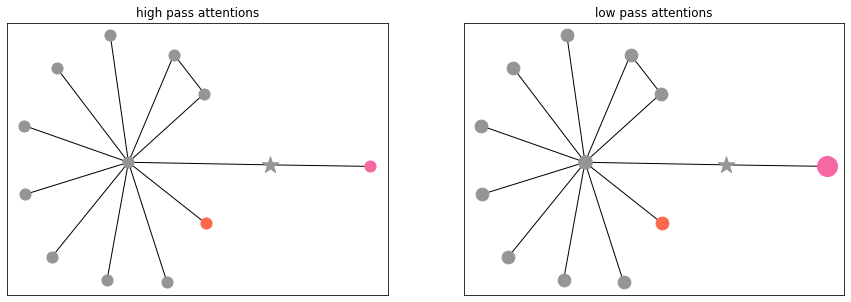

In [121]:
low_attentions = torch.stack(low_att1, 0).sum(0)
high_attentions = torch.stack(high_att1, 0).sum(0)

index = 5
node = high_not_low_correct_nodes[index].item()
# node = low_not_high_correct_nodes[2].item()

Gego = nx.ego_graph(G, node, 2)
nodePos = nx.layout.spring_layout(Gego)

plt.figure(figsize=(15,5))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high pass attentions')

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           ax=ax1,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.5)],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else (high_attentions[node, n]*400).clamp(max=400, min=20))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5, ax=ax1)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low pass attentions')

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           ax=ax2,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.5)],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else (low_attentions[node, n]*400).clamp(max=400, min=20))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5, ax=ax2)

plt.show()

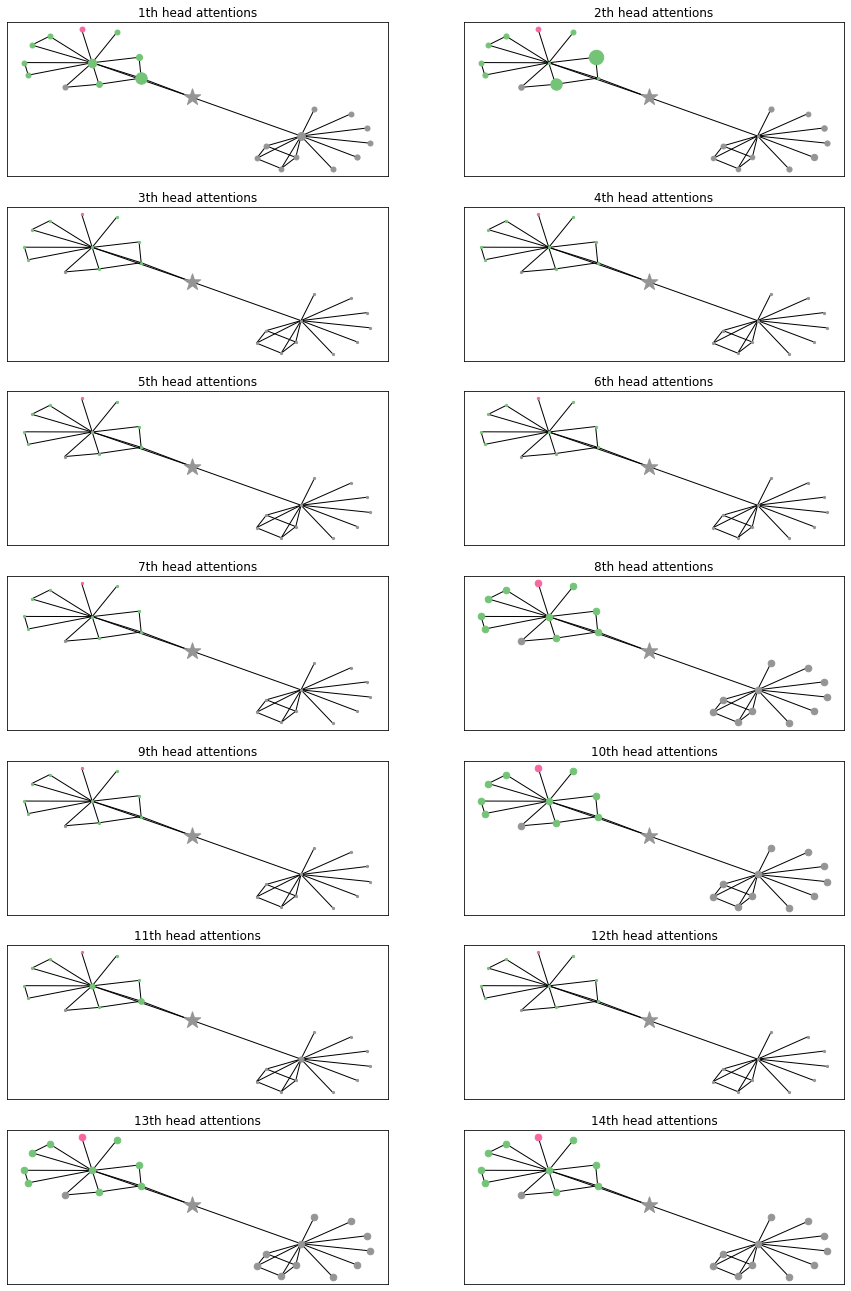

In [123]:
# low_attentions = torch.stack(low_att1, 0).sum(0)
# high_attentions = torch.stack(high_att1, 0).sum(0)

index = 6
node = high_not_low_correct_nodes[index].item()
# node = low_not_high_correct_nodes[index].item()

Gego = nx.ego_graph(G, node, 2)
nodePos = nx.layout.spring_layout(Gego)

plt.figure(figsize=(15,30))

for i in range(heads):
    ax = plt.subplot(9, 2, i+1)
    ax.set_title(str(i+1) + 'th head attentions')

#     print([att1[i][node, n].item() for n in Gego.nodes])
    for n in Gego.nodes:
        nx.draw_networkx_nodes(Gego, nodePos,
                               ax=ax,
                               nodelist=[n],
                               node_color=[node_colors[dataset[0].y[n].item()](0.5)],
                               node_shape="*" if n == node else "o",
                               node_size=300 if n == node else (att1[i][node, n]*1000).clamp(max=400, min=5))
    nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5, ax=ax)
plt.show()

Attended node centrality distribution by frequency bands

In [124]:
# compute all node's centrality
centrality_between = nx.betweenness_centrality(G)
centrality_degree = nx.degree_centrality(G)
centrality_close = nx.closeness_centrality(G)
centrality_eigen = nx.eigenvector_centrality(G)

Degree centrality
high-pass centrality mean: 0.0007517623016610742, std: 0.001312602311372757
low-pass centrality mean: 0.000895306293386966, std: 0.0013277808902785182

Betweeness centrality
high-pass centrality mean: 0.0008892528712749481, std: 0.004006777424365282
low-pass centrality mean: 0.0012096225982531905, std: 0.004478680435568094

Closeness centrality
high-pass centrality mean: 0.03601938858628273, std: 0.036449939012527466
low-pass centrality mean: 0.04148750379681587, std: 0.034750401973724365

Eigen centrality
high-pass centrality mean: 0.0032677811104804277, std: 0.02111167274415493
low-pass centrality mean: 0.002432297682389617, std: 0.019370058551430702


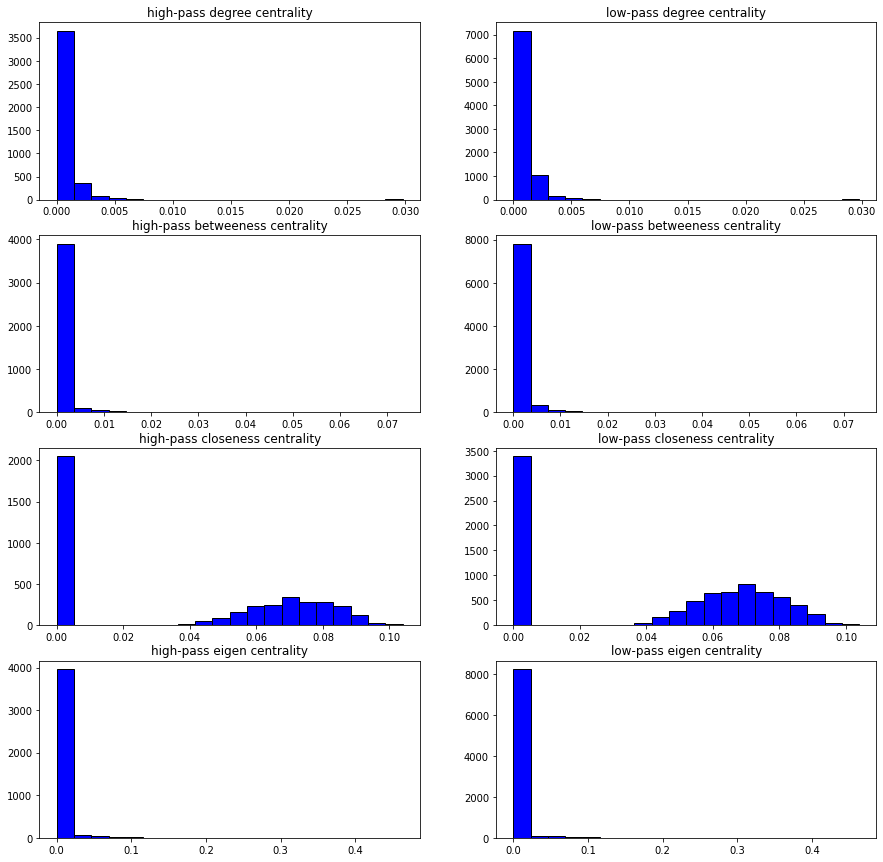

In [126]:
min_att = 1
plt.figure(figsize=(15,15))

print('Degree centrality')
ax1 = plt.subplot(4, 2, 1)
ax1.set_title('high-pass degree centrality')
centralities = torch.tensor([centrality_degree[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

ax2 = plt.subplot(4, 2, 2)
ax2.set_title('low-pass degree centrality')
centralities = torch.tensor([centrality_degree[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

print('\nBetweeness centrality')
ax3 = plt.subplot(4, 2, 3)
ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

ax4 = plt.subplot(4, 2, 4)
ax4.set_title('low-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

print('\nCloseness centrality')
ax5 = plt.subplot(4, 2, 5)
ax5.set_title('high-pass closeness centrality')
centralities = torch.tensor([centrality_close[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

ax6 = plt.subplot(4, 2, 6)
ax6.set_title('low-pass closeness centrality')
centralities = torch.tensor([centrality_close[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

print('\nEigen centrality')
ax7 = plt.subplot(4, 2, 7)
ax7.set_title('high-pass eigen centrality')
centralities = torch.tensor([centrality_eigen[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)


ax8 = plt.subplot(4, 2, 8)
ax8.set_title('low-pass eigen centrality')
centralities = torch.tensor([centrality_eigen[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);

Attended node page rank distribution by frequency bands

Page Rank
high-pass  page rank mean: 0.0003032942219767618, std: 0.0002581054545828176
low-pass page rank mean: 0.0003389950388768384, std: 0.0002890852496913017


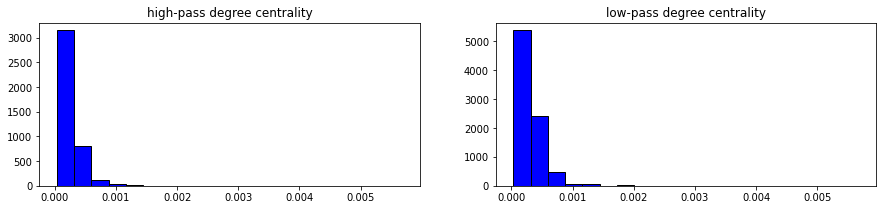

In [127]:
# compute all node's page rank
pr = nx.pagerank(G, alpha=0.9)

min_att = 1
plt.figure(figsize=(15,3))

print('Page Rank')
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high-pass degree centrality')
prs = torch.tensor([pr[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass  page rank mean: {}, std: {}'.format(prs.mean().item(), prs.std().item()))
plt.hist(prs, color = 'blue', edgecolor = 'black', bins = 20)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low-pass degree centrality')
prs = torch.tensor([pr[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass page rank mean: {}, std: {}'.format(prs.mean().item(), prs.std().item()))
plt.hist(prs, color = 'blue', edgecolor = 'black', bins = 20);

Distance distribution of attended node

Attended node distance
high-pass node distance mean: 1.6864516735076904, std: 0.5896118879318237
low-pass node distance mean: 1.6864516735076904, std: 0.5896118879318237


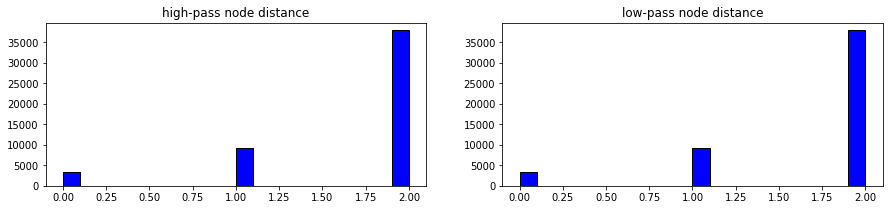

In [139]:
# Compute distances to from a node to its attended nodes
min_att = 0

high_distances = []

masked_high_attenions = high_attentions > min_att
for n1 in G.nodes:
    for n2 in G.nodes:
        if masked_high_attenions[n1, n2]:
            high_distances.append(nx.shortest_path_length(G, n1, n2))

low_distances = []

masked_low_attenions = low_attentions > min_att
for n1 in G.nodes:
    for n2 in G.nodes:
        if masked_low_attenions[n1, n2]:
            low_distances.append(nx.shortest_path_length(G, n1, n2))

            
plt.figure(figsize=(15,3))

print('Attended node distance')
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high-pass node distance')
distances = torch.tensor(high_distances).float()
print('high-pass node distance mean: {}, std: {}'.format(distances.mean().item(), distances.std().item()))
plt.hist(distances, color = 'blue', edgecolor = 'black', bins = 20)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low-pass node distance')
distances = torch.tensor(low_distances).float()
print('low-pass node distance mean: {}, std: {}'.format(distances.mean().item(), distances.std().item()))
plt.hist(distances, color = 'blue', edgecolor = 'black', bins = 20);

Re-train model with cutoff

In [27]:
# Similar result as cutoff after training
# from citation import run
#
# model_cutoff = Net(dataset)
#
# max_cutoff=1
# cutoff_kernel = model_cutoff.analysis.filter_kernel
# model_cutoff.analysis.filter_kernel = CutOff(max_val=max_cutoff, kernel=cutoff_kernel)
# model_cutoff.analysis.filter._kernel = CutOff(max_val=max_cutoff, kernel=cutoff_kernel)
#
# plot_filter_banks(kernel=model_cutoff.analysis.filter_kernel)
# print(evaluate(model_cutoff, dataset[0]))
#
# run(dataset, model_cutoff, runs, epochs, lr, weight_decay, patience, None)
#
# plot_filter_banks(kernel=model_cutoff.analysis.filter_kernel)
# print(evaluate(model_cutoff, dataset[0]))


## Evaluate filterbanks

Define kernel to eliminate certain filterbanks

In [49]:
class Elimination(nn.Module):
    def __init__(self, zero_out_indices):
        super(Elimination, self).__init__()
        self.zero_out_indices = zero_out_indices

    def reset_parameters(self):
        pass

    def forward(self, x):
        x = filter_kernel(x)
        x[:, self.zero_out_indices] = torch.zeros(x.shape[0], len(self.zero_out_indices))
        return x

Evaluate each filter bank

In [50]:
all_indices = set(list(range(heads)))
diff= []
for i in range(heads):
    zero_out_filters = list(all_indices.difference({i}))
    model.analysis.filter_kernel = Elimination(zero_out_filters)
    model.analysis.filter._kernel = Elimination(zero_out_filters)
    # plot_filter_banks(kernel=model.analysis.filter_kernel)
    test_acc = evaluate(model, dataset[0])['test_acc']
    diff.append(test_acc - eval_info['test_acc'])
print(' & '.join(['{:.2f}\%'.format(d*100) for d in diff]))

-1.80\% & -2.00\% & -1.70\% & -1.70\% & -1.80\% & -1.80\% & -1.70\% & -1.90\% & -1.70\% & -1.90\% & -1.70\% & -1.70\% & -1.90\% & -1.90\%


Evaluate by eliminating only one filter bank

In [246]:
diff= []
for i in range(heads):
    model.analysis.filter_kernel = Elimination([i])
    model.analysis.filter._kernel = Elimination([i])
    # plot_filter_banks(kernel=model.analysis.filter_kernel)
    test_acc = evaluate(model, dataset[0])['test_acc']
    diff.append(test_acc - eval_info['test_acc'])
print(' & '.join(['{:.2f}\%'.format(d*100) for d in diff]))


<>:8: DeprecationWarning: invalid escape sequence \%


-0.20\% & -0.30\% & -0.70\% & -0.70\% & -0.40\% & -0.60\% & -0.80\% & 0.00\% & -0.60\% & 0.00\% & -0.80\% & -0.50\% & 0.00\% & 0.00\%


Load GAT model

In [11]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self, dataset):
        super(GAT, self).__init__()
        self.conv1 = GATConv(
            dataset.num_features,
            8,
            heads=8,
            dropout=0.6)
        self.conv2 = GATConv(
            64,
            dataset.num_classes,
            heads=1,
            concat=False,
            dropout=0.6)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x, (edge_index_1, att_val_1) = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x, (edge_index_2, att_val_2) = self.conv2(x, edge_index, return_attention_weights=True)
        att1 = torch.zeros(data.num_nodes, data.num_nodes, 8)
        att2 = torch.zeros(data.num_nodes, data.num_nodes)
        att1[list(map(lambda x: torch.tensor(x), edge_index_1.tolist()))] = att_val_1
        att2[list(map(lambda x: torch.tensor(x), edge_index_2.tolist()))] = att_val_2.view(-1)
        return F.log_softmax(x, dim=1), att1, att2

gat = GAT(dataset)


gat.load_state_dict(torch.load('./model/best_{}_gat.pkl'.format(dataset_name)))
gat_correct_indices = get_correctly_predicted_node_idx(gat, 'test', dataset)

with torch.no_grad():
    _, gat_att1, gat_att2 = gat(dataset[0])
evaluate(gat, dataset[0])

{'train_loss': 0.8178199529647827,
 'train_acc': 0.8106185002736727,
 'train_micro_f1': 0.8106185002736727,
 'train_macro_f1': 0.752694071215192,
 'val_loss': 0.8965532183647156,
 'val_acc': 0.81,
 'val_micro_f1': 0.81,
 'val_macro_f1': 0.7323837199957008,
 'test_loss': 0.8940090537071228,
 'test_acc': 0.778,
 'test_micro_f1': 0.778,
 'test_macro_f1': 0.7017280495800026}

In [12]:
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self, dataset):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 64)
        self.conv2 = GCNConv(64, dataset.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1), None
    
gcn = GCN(dataset)
gcn.load_state_dict(torch.load('./model/best_Citeseer_gcn.pkl'.format(dataset_name)))
gcn_correct_indices = get_correctly_predicted_node_idx(gcn, 'test', dataset)

evaluate(gcn, dataset[0])

{'train_loss': 0.6749608516693115,
 'train_acc': 0.8166392993979201,
 'train_micro_f1': 0.8166392993979201,
 'train_macro_f1': 0.774800487449197,
 'val_loss': 0.7802919745445251,
 'val_acc': 0.82,
 'val_micro_f1': 0.82,
 'val_macro_f1': 0.7548710129806285,
 'test_loss': 0.7651001214981079,
 'test_acc': 0.788,
 'test_micro_f1': 0.788,
 'test_macro_f1': 0.7265195784607675}

In [13]:
from torch_geometric.nn import SGConv

class SGC(torch.nn.Module):
    def __init__(self, dataset):
        super(SGC, self).__init__()
        self.conv1 = SGConv(
            dataset.num_features, dataset.num_classes, K=2, cached=True)

    def reset_parameters(self):
        self.conv1.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1), None

dataset_unnormalized = get_dataset(dataset_name, False, edge_dropout=edge_dropout,
                                node_feature_dropout=node_feature_dropout)
sgc = SGC(dataset_unnormalized)
sgc.load_state_dict(torch.load('./model/best_Citeseer_sgc.pkl'.format(dataset_name)))
sgc_correct_indices = get_correctly_predicted_node_idx(sgc, 'test', dataset_unnormalized)

evaluate(sgc, dataset_unnormalized[0])

{'train_loss': 0.6347513198852539,
 'train_acc': 0.7991242474001095,
 'train_micro_f1': 0.7991242474001096,
 'train_macro_f1': 0.7217705986934555,
 'val_loss': 0.8052297830581665,
 'val_acc': 0.786,
 'val_micro_f1': 0.786,
 'val_macro_f1': 0.708295666957094,
 'test_loss': 0.8246657252311707,
 'test_acc': 0.76,
 'test_micro_f1': 0.76,
 'test_macro_f1': 0.6788085029293738}

In [14]:
from torch_geometric.nn import ChebConv


class Cheb(torch.nn.Module):
    def __init__(self, dataset):
        super(Cheb, self).__init__()
        self.conv1 = ChebConv(dataset.num_features, 16, 2)
        self.conv2 = ChebConv(16, dataset.num_classes, 2)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1), None
    
cheb = Cheb(dataset)
cheb.load_state_dict(torch.load('./model/best_Citeseer_cheb.pkl'.format(dataset_name)))
cheb_correct_indices = get_correctly_predicted_node_idx(cheb, 'test', dataset)

evaluate(cheb, dataset[0])

{'train_loss': 0.5563210248947144,
 'train_acc': 0.8571428571428571,
 'train_micro_f1': 0.8571428571428571,
 'train_macro_f1': 0.8231449202874553,
 'val_loss': 0.7509323358535767,
 'val_acc': 0.81,
 'val_micro_f1': 0.81,
 'val_macro_f1': 0.749923239713278,
 'test_loss': 0.7448410391807556,
 'test_acc': 0.795,
 'test_micro_f1': 0.795,
 'test_macro_f1': 0.7489021889562496}

In [15]:
from torch_geometric.nn import APPNP
from torch.nn import Linear

class Appnp(torch.nn.Module):
    def __init__(self, dataset):
        super(Appnp, self).__init__()
        self.lin1 = Linear(dataset.num_features, 64)
        self.lin2 = Linear(64, dataset.num_classes)
        self.prop1 = APPNP(10, 0.1)

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.prop1(x, edge_index)
        return F.log_softmax(x, dim=1), None
    
appnp = Appnp(dataset)
appnp.load_state_dict(torch.load('./model/best_Citeseer_appnp.pkl'.format(dataset_name)))
appnp_correct_indices = get_correctly_predicted_node_idx(appnp, 'test', dataset)

evaluate(appnp, dataset[0])

{'train_loss': 0.6745723485946655,
 'train_acc': 0.8084291187739464,
 'train_micro_f1': 0.8084291187739464,
 'train_macro_f1': 0.7642930514952312,
 'val_loss': 0.7715176939964294,
 'val_acc': 0.806,
 'val_micro_f1': 0.806,
 'val_macro_f1': 0.7440469383028852,
 'test_loss': 0.758247971534729,
 'test_acc': 0.78,
 'test_micro_f1': 0.78,
 'test_macro_f1': 0.7115224574368039}

In [16]:
from torch_geometric.nn import ARMAConv

class ARMA(torch.nn.Module):
    def __init__(self, dataset):
        super(ARMA, self).__init__()
        self.conv1 = ARMAConv(
            dataset.num_features,
            16,
            1,
            1,
            False,
            dropout=0.75)
        self.conv2 = ARMAConv(
            16,
            dataset.num_classes,
            1,
            1,
            False,
            dropout=0.75)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1), None
    
arma = ARMA(dataset)
arma.load_state_dict(torch.load('./model/best_Citeseer_arma.pkl'.format(dataset_name)))
arma_correct_indices = get_correctly_predicted_node_idx(arma, 'test', dataset)

evaluate(arma, dataset[0])


{'train_loss': 0.6257728338241577,
 'train_acc': 0.8423645320197044,
 'train_micro_f1': 0.8423645320197044,
 'train_macro_f1': 0.8091883102701386,
 'val_loss': 0.8025183081626892,
 'val_acc': 0.81,
 'val_micro_f1': 0.81,
 'val_macro_f1': 0.7501653767595796,
 'test_loss': 0.7884925007820129,
 'test_acc': 0.776,
 'test_micro_f1': 0.776,
 'test_macro_f1': 0.7086076966103213}

In [17]:
from torch_geometric.nn import ARMAConv

class MLP(torch.nn.Module):
    def __init__(self, dataset):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(nn.Linear(dataset[0].num_node_features, 64),
                                nn.Dropout(0.8),
                                nn.Linear(64, dataset.num_classes),
                                nn.ReLU(inplace=True),
                                nn.LogSoftmax(dim=1))

    def reset_parameters(self):
        for layer in self.layers:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def forward(self, data):
        x = data.x
        return self.layers(x), None, None

mlp = MLP(dataset)
mlp.load_state_dict(torch.load('./model/best_{}_mlp.pkl'.format(dataset_name)))
mlp_correct_indices = get_correctly_predicted_node_idx(mlp, 'test', dataset)

evaluate(mlp, dataset[0])

{'train_loss': 0.42962929606437683,
 'train_acc': 0.9102353585112206,
 'train_micro_f1': 0.9102353585112206,
 'train_macro_f1': 0.8653994580165002,
 'val_loss': 0.8128601908683777,
 'val_acc': 0.752,
 'val_micro_f1': 0.752,
 'val_macro_f1': 0.6854480329526466,
 'test_loss': 0.8103276491165161,
 'test_acc': 0.756,
 'test_micro_f1': 0.756,
 'test_macro_f1': 0.6821793249114262}

In [18]:
from random import choice
from collections import Counter
from scipy.sparse import coo_matrix
import networkx as nx


def multimode(eles, num_classes):
    res = []
    if(len(eles) == 0):
        eles = list(range(num_classes))
    counter = Counter(eles)
    temp = counter.most_common(1)[0][1]
    for ele in eles:
      if eles.count(ele) == temp:
        res.append(ele)
    return list(set(res))

class MajorityVote(torch.nn.Module):
    def __init__(self, dataset):
        super(MajorityVote, self).__init__()
        self.num_classes = dataset.num_classes
        adj = coo_matrix(
            (np.ones(dataset[0].num_edges),
             (dataset[0].edge_index[0].numpy(), dataset[0].edge_index[1].numpy())),
            shape=(dataset[0].num_nodes, dataset[0].num_nodes))
        self.G = nx.Graph(adj)
        
    def forward(self, data):
        train_nodes = set(data.train_mask.nonzero().view(-1).tolist())

        logits = []
        for n in range(data.num_nodes):
            hop_1_neighbours = set(nx.ego_graph(self.G, n, 1).nodes())
            hop_1_labels = data.y[list(hop_1_neighbours)]
            label = choice(multimode(hop_1_labels.tolist(), self.num_classes))
            logits.append(F.one_hot(torch.tensor(label), self.num_classes).float())
        return torch.stack(logits, 0), None
    
majority_vote = MajorityVote(dataset)
# arma_correct_indices = get_correctly_predicted_node_idx(arma, 'test', dataset)

evaluate(majority_vote, dataset[0])

{'train_loss': -0.8500273823738098,
 'train_acc': 0.8500273672687466,
 'train_micro_f1': 0.8500273672687466,
 'train_macro_f1': 0.8327738911556355,
 'val_loss': -0.8679999709129333,
 'val_acc': 0.868,
 'val_micro_f1': 0.868,
 'val_macro_f1': 0.842520557996031,
 'test_loss': -0.8759999871253967,
 'test_acc': 0.876,
 'test_micro_f1': 0.8759999999999999,
 'test_macro_f1': 0.857494909102209}

In [19]:
np.sum([torch.prod(torch.tensor(p.shape)) for p in list(gat.parameters())])

237586

In [20]:
np.sum([torch.prod(torch.tensor(p.shape)) for p in list(model.parameters())])

130191

In [104]:
(torch.tensor(label_distributions[0])<2).nonzero().shape

torch.Size([1000, 1])

In [111]:
step = 0.1
def cal_acc_in_noisy_neighbourhood(m, dataset):
    m.eval()
    accs = []
    with torch.no_grad():
        logits  = m(dataset[0])[0]
    for p in torch.arange(step, 1.1, step):
        dissimilar_neighbhour_nodes_mask = dataset[0]['test_mask'].clone()
        dissimilar_neighbhour_nodes_mask[dissimilar_neighbhour_nodes_mask] = (torch.tensor(label_distributions[0]) <= p).logical_and(torch.tensor(label_distributions[0]) >= p - step)
        mask = dissimilar_neighbhour_nodes_mask
        pred = logits[mask].max(1)[1]
        accs.append(pred.eq(dataset[0].y[mask]).sum().item() / mask.sum().item())
    return accs

# Try to get some standard deviations 

In [112]:
model_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(model, dataset))
gat_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(gat, dataset))
gcn_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(gcn, dataset))
sgc_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(sgc, dataset_unnormalized))
cheb_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(cheb, dataset))
appnp_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(appnp, dataset))
arma_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(arma, dataset))
majority_vote_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(majority_vote, dataset))
mlp_noisy_accs = torch.tensor(cal_acc_in_noisy_neighbourhood(mlp, dataset))

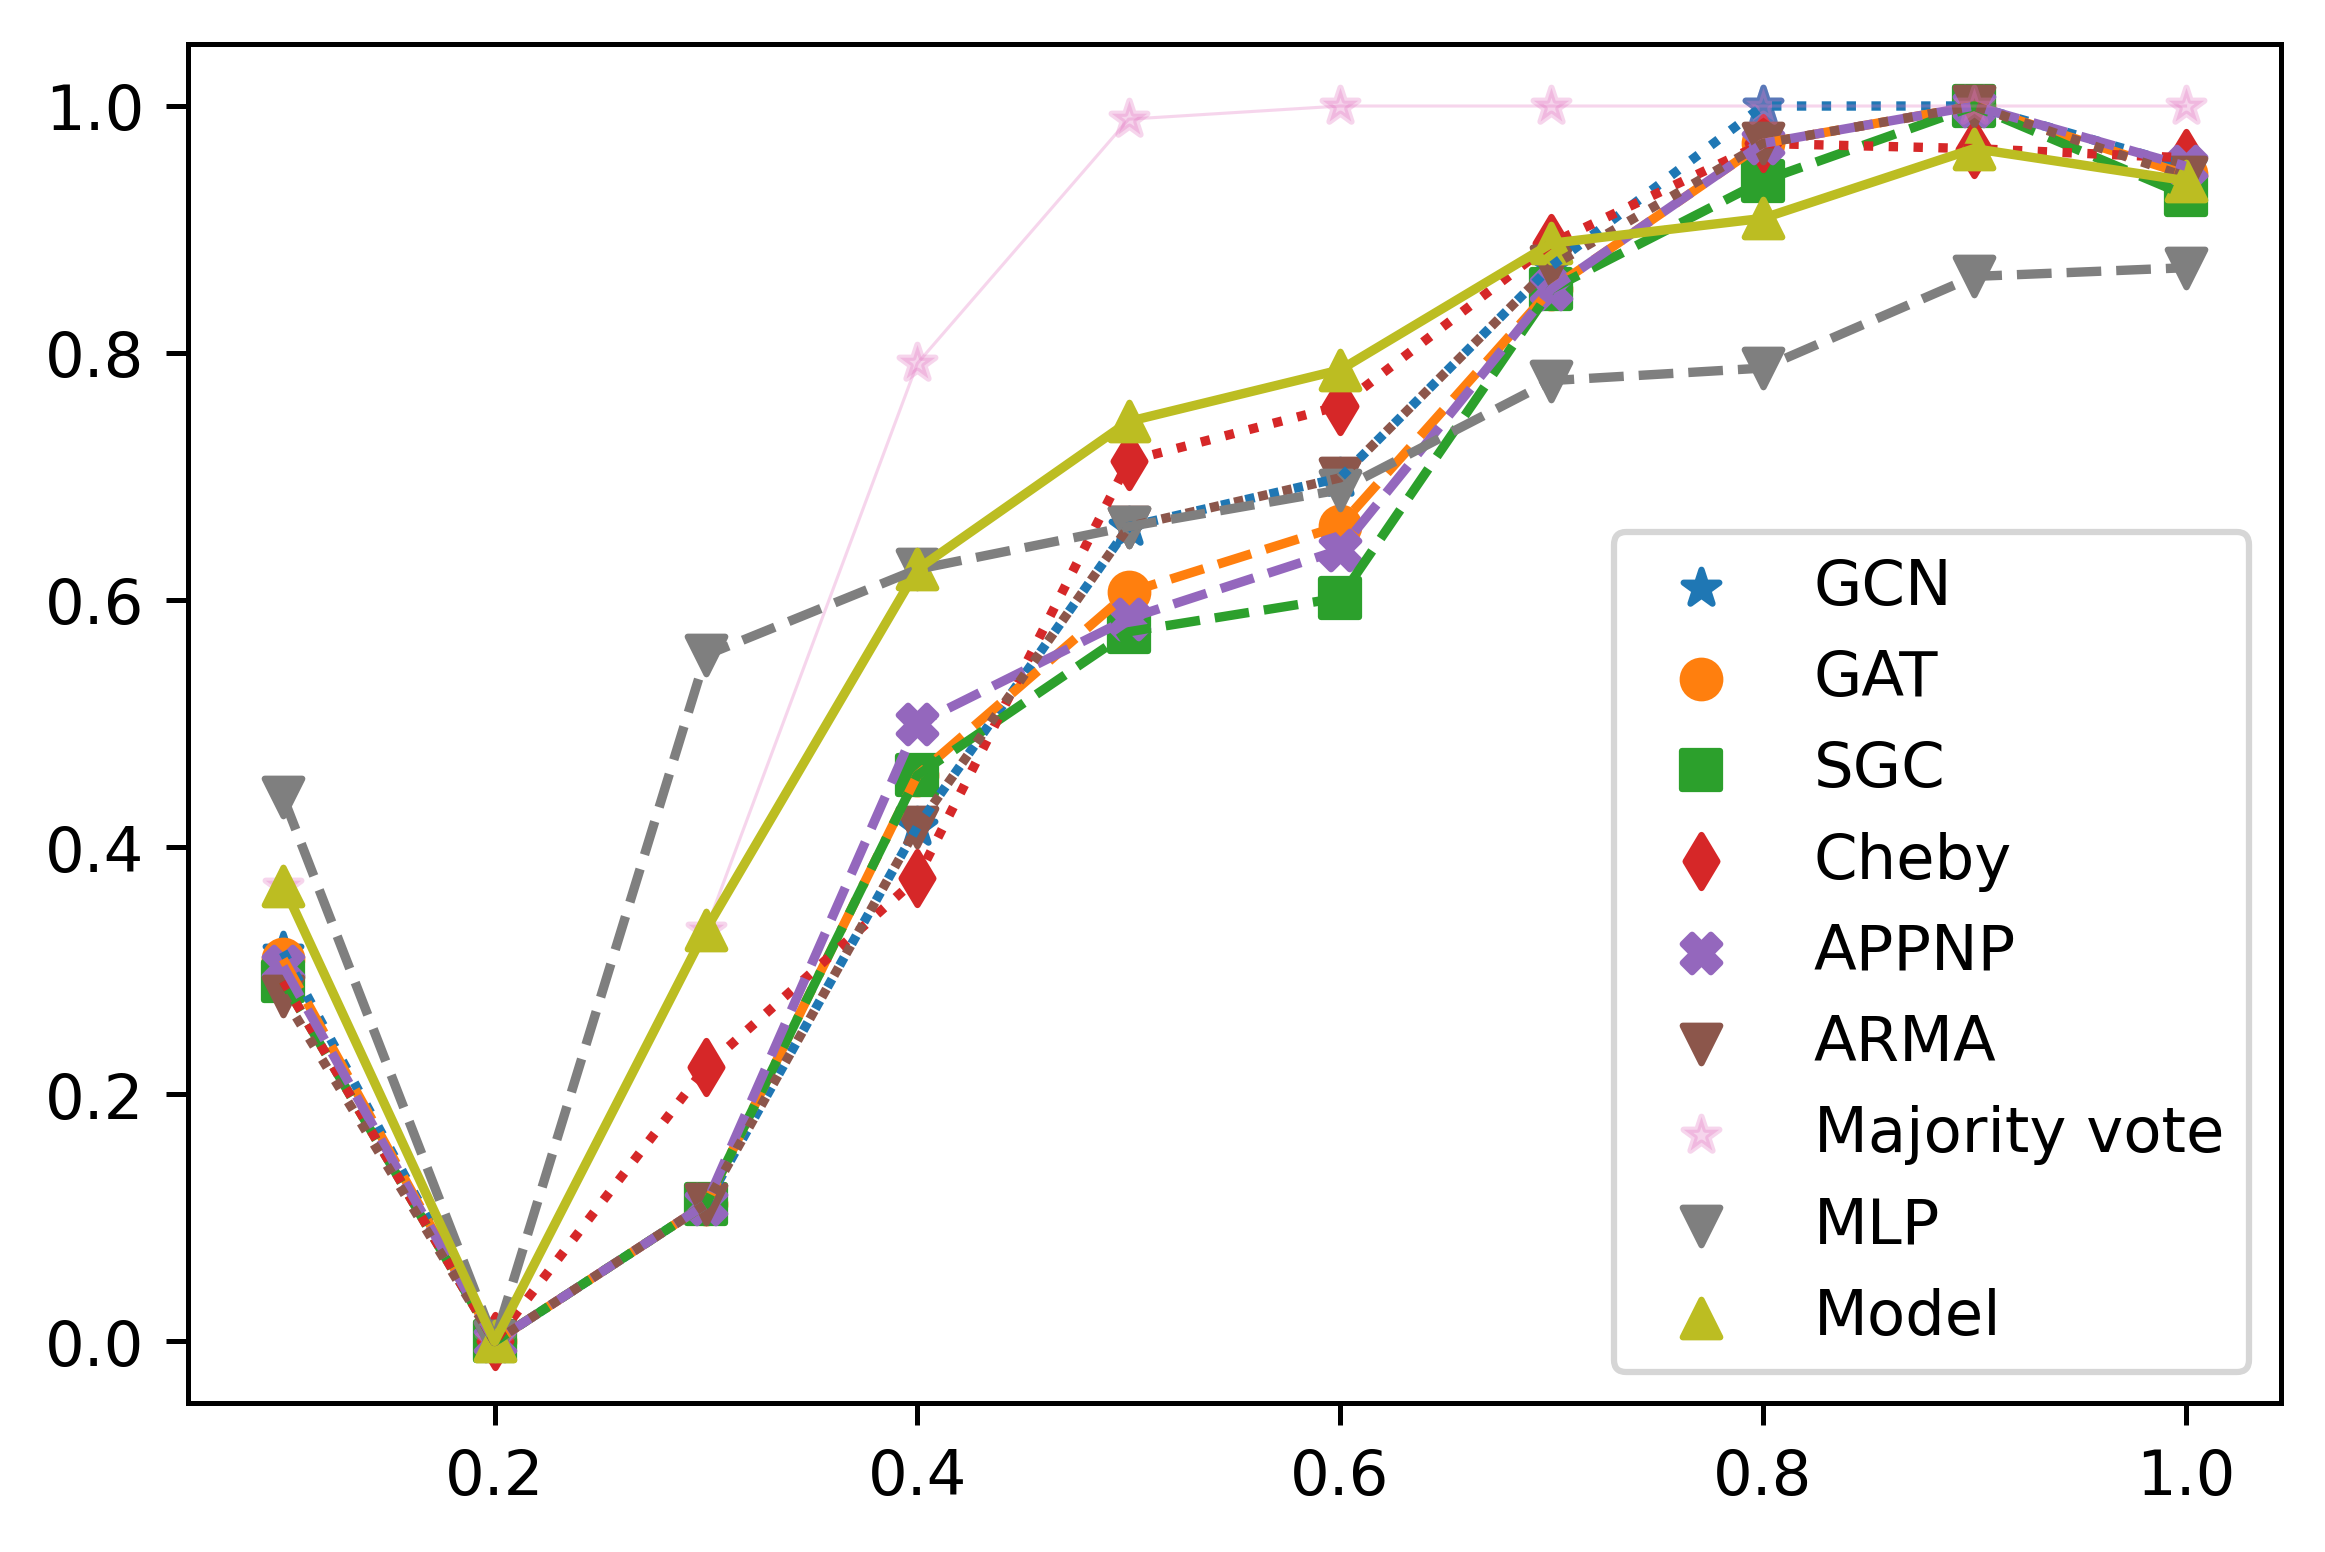

In [113]:
plt.figure(dpi=450)
x = torch.arange(step, 1.1, step).tolist()
plt.plot(x,
         gcn_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         gat_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         sgc_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         cheb_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         appnp_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         arma_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         majority_vote_noisy_accs,
         linestyle='-',
         linewidth=0.5,
         alpha=0.3,
         zorder=2)
plt.plot(x,
         mlp_noisy_accs,
         linewidth=1.5,
         linestyle='--',
         zorder=2)
plt.plot(x,
         model_noisy_accs,
         linewidth=1.5,
         linestyle='-',
         zorder=2)

s1 = plt.scatter(x, gcn_noisy_accs, zorder=1, marker='*')
s2 = plt.scatter(x, gat_noisy_accs, zorder=1, marker="o")
s3 = plt.scatter(x, sgc_noisy_accs, zorder=1, marker='s')
s4 = plt.scatter(x, cheb_noisy_accs, zorder=1, marker='d')
s5 = plt.scatter(x, appnp_noisy_accs, zorder=1, marker='X')
s6 = plt.scatter(x, arma_noisy_accs, zorder=1, marker='v')
s7 = plt.scatter(x, majority_vote_noisy_accs, zorder=1, marker='*', alpha=0.3)
s8 = plt.scatter(x, mlp_noisy_accs, zorder=1, marker='v')
s9 = plt.scatter(x, model_noisy_accs, zorder=1, marker='^')
plt.legend((s1, s2, s3, s4, s5, s6, s7, s8, s9), ('GCN', 'GAT', 'SGC', 'Cheby', 'APPNP', 'ARMA', 'Majority vote', 'MLP', 'Model'))
# plt.legend((s1, s3, s4, s5, s7, s8, s9), ('GCN', 'SGC', 'Cheby', 'APPNP','Majority vote', 'MLP', 'Model'))

data_2_save = {
    'x': x,
    'labels': ['GCN', 'GAT', 'SGC', 'Cheby', 'APPNP', 'ARMA', 'Majority vote', 'MLP', 'Model'],
    'accs': [gcn_noisy_accs, gat_noisy_accs, sgc_noisy_accs, appnp_noisy_accs, arma_noisy_accs, majority_vote_noisy_accs, mlp_noisy_accs, model_noisy_accs]
}
torch.save(data_2_save, './citeseer_beta_acc.pkl')

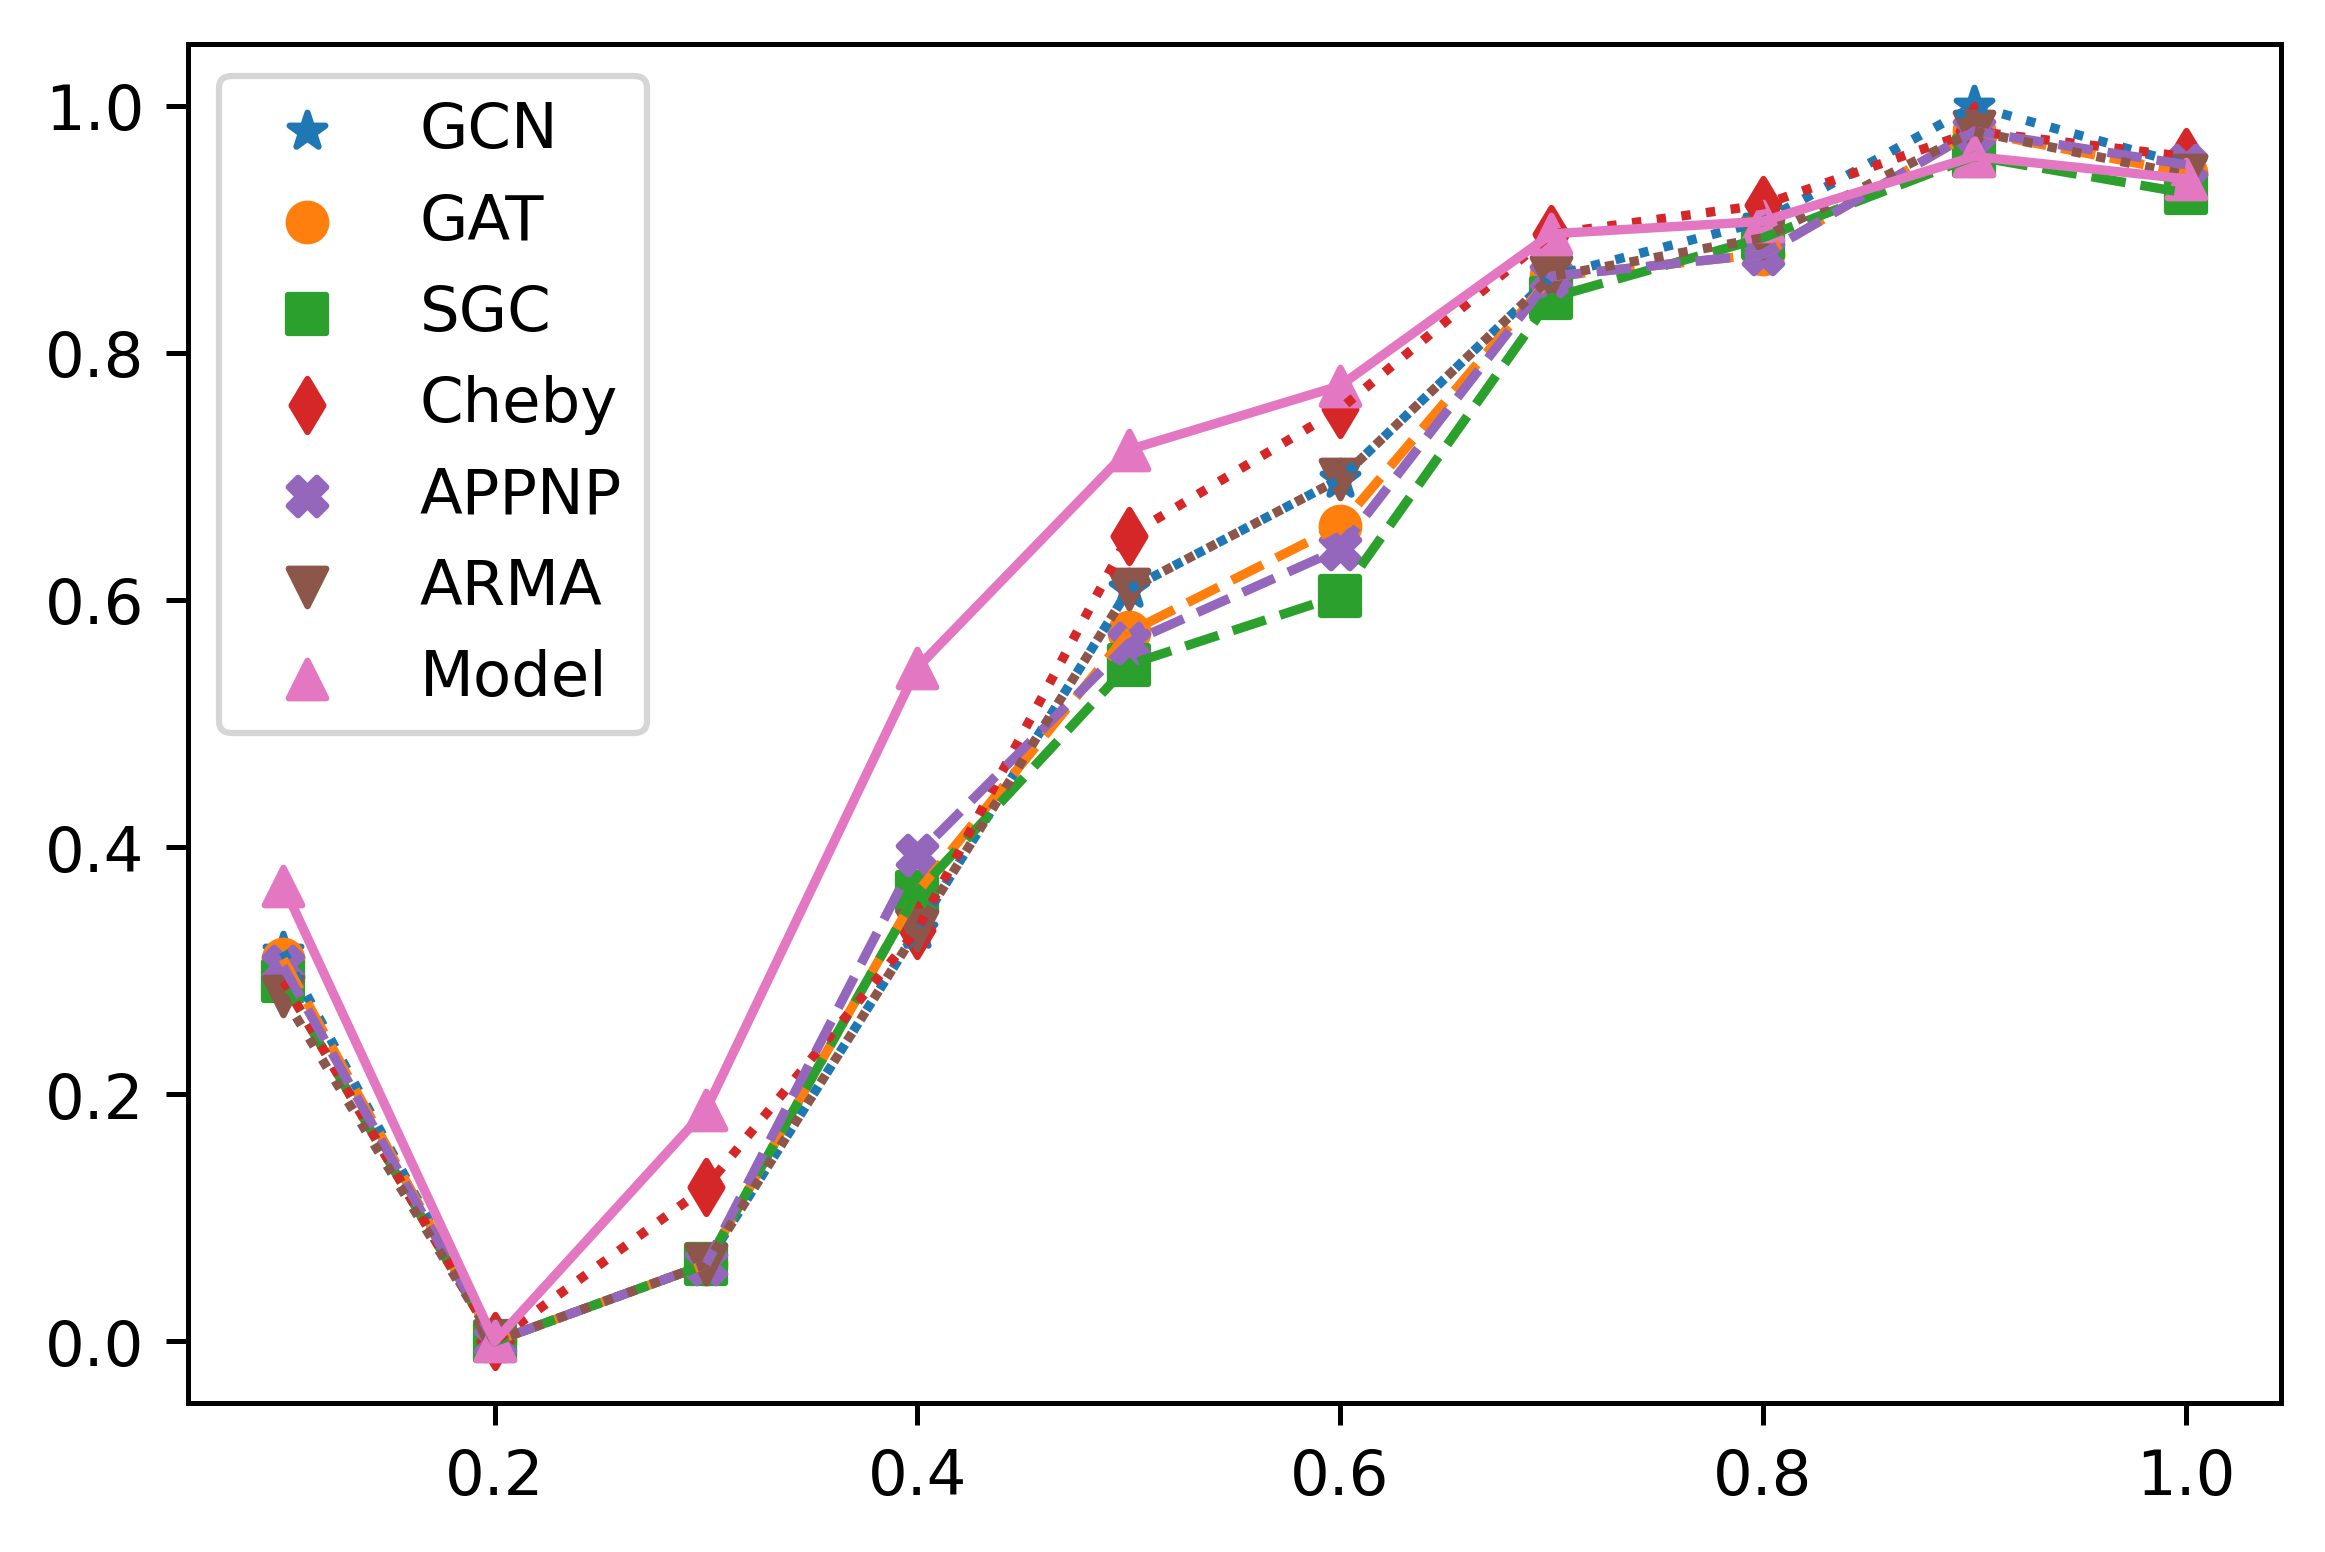

In [67]:
plt.figure(dpi=450)
x = torch.arange(0.1, 1.1, 0.1).tolist()
plt.plot(x,
         gcn_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         gat_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         sgc_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         cheb_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         appnp_noisy_accs,
         linestyle='--',
         zorder=2)
plt.plot(x,
         arma_noisy_accs,
         linestyle=':',
         zorder=2)
plt.plot(x,
         model_noisy_accs,
         linewidth=1.5,
         linestyle='-',
         zorder=2)

s1 = plt.scatter(x, gcn_noisy_accs, zorder=1, marker='*')
s2 = plt.scatter(x, gat_noisy_accs, zorder=1, marker="o")
s3 = plt.scatter(x, sgc_noisy_accs, zorder=1, marker='s')
s4 = plt.scatter(x, cheb_noisy_accs, zorder=1, marker='d')
s5 = plt.scatter(x, appnp_noisy_accs, zorder=1, marker='X')
s6 = plt.scatter(x, arma_noisy_accs, zorder=1, marker='v')
s7 = plt.scatter(x, model_noisy_accs, zorder=1, marker='^')
plt.legend((s1, s2, s3, s4, s5, s6, s7), ('GCN', 'GAT', 'SGC', 'Cheby', 'APPNP', 'ARMA', 'Model'))

tensor(0.0389)

Comparison with GAT

In [37]:
model_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices)]
gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(gat_correct_indices)]
model_not_gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices.difference(gat_correct_indices))]
model_and_gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices.intersection(gat_correct_indices))]
gat_not_model_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(gat_correct_indices.difference(model_correct_indices))]
gat_and_model_incorrect_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(set(dataset[0].y[dataset[0]['test_mask']].nonzero().view(-1).tolist()).difference(model_correct_indices).difference(gat_correct_indices))]
print('Number of node classified correctly by our model:', len(model_correct_nodes))
print('Number of node classified correctly by GAT:', len(gat_correct_nodes))
print('Number of node classified correctly by our model but not by GAT:', len(model_not_gat_correct_nodes))
print('Number of node classified correctly by both GAT and our model:', len(model_and_gat_correct_nodes))
print('Number of node classified correctly by GAT but not by our model:', len(gat_not_model_correct_nodes))
print('Number of node classified incorrectly by GAT and our model:', len(gat_and_model_incorrect_nodes))


Number of node classified correctly by our model: 805
Number of node classified correctly by GAT: 778
Number of node classified correctly by our model but not by GAT: 59
Number of node classified correctly by both GAT and our model: 746
Number of node classified correctly by GAT but not by our model: 32
Number of node classified incorrectly by GAT and our model: 118


In [38]:
gat_att1_sum = gat_att1.sum(dim=2)

In [39]:
node = model_not_gat_correct_nodes[1].item()
Gego = nx.ego_graph(G, node, 2)
nodePos = nx.layout.spring_layout(Gego)
plt.figure()
for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.8)],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else (model_att1_sum[node, n]*200).clamp(max=400, min=5))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5)


plt.figure()
for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=[node_colors[dataset[0].y[n].item()](0.8)],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else (gat_att1_sum[node, n]*200).clamp(max=400, min=5))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5)



NameError: name 'node_colors' is not defined

<Figure size 432x288 with 0 Axes>

Label distribution of nodes classified correctly by our model


Betweeness centrality
high-pass centrality mean: 0.0031025800853967667, std: 0.008951541967689991


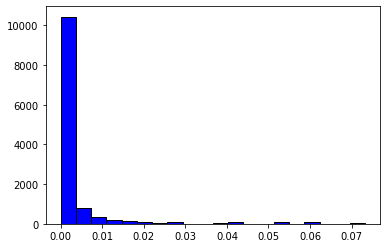

In [199]:
print('\nBetweeness centrality')
ax3 = plt.subplot(1, 1, 1)
# ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (gat_att1_sum).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);


Betweeness centrality
high-pass centrality mean: 0.003282387275248766, std: 0.008437315002083778


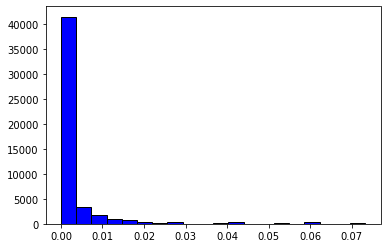

In [200]:
print('\nBetweeness centrality')
ax3 = plt.subplot(1, 1, 1)
# ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (model_att1_sum).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);

matching labels in 1st hop: tensor(0.8937)
matching labels in 2st hop: tensor(0.8390)
matching labels in 3rd hop: tensor(0.7911)


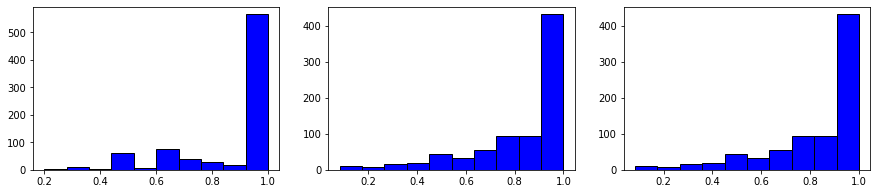

In [202]:
matching_labels_distribution(model_correct_nodes);

In [221]:
min_att = 0.2

Label distribution of nodes classified correctly by our model


Betweeness centrality
high-pass centrality mean: 0.0024233979638665915, std: 0.0065828170627355576


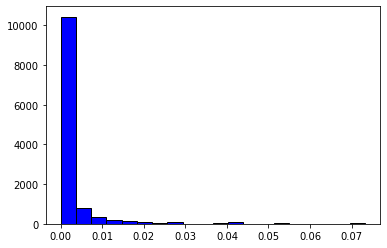

In [222]:
print('\nBetweeness centrality')
ax3 = plt.subplot(1, 1, 1)
# ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (gat_att1_sum > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);


Betweeness centrality
high-pass centrality mean: 0.002925171982496977, std: 0.007751181721687317


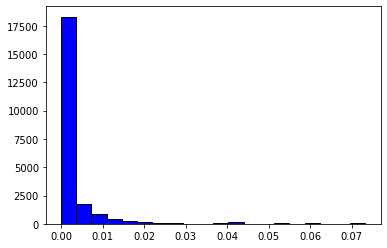

In [223]:
print('\nBetweeness centrality')
ax3 = plt.subplot(1, 1, 1)
# ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (model_att1_sum > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);

matching labels in 1st hop: tensor(0.8937)
matching labels in 2st hop: tensor(0.8390)
matching labels in 3rd hop: tensor(0.7911)


([tensor(0.6000),
  tensor(0.5714),
  tensor(0.6667),
  tensor(0.9167),
  tensor(0.5000),
  tensor(1.),
  tensor(1.),
  tensor(0.7143),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.6667),
  tensor(1.),
  tensor(1.),
  tensor(0.5000),
  tensor(0.5714),
  tensor(1.),
  tensor(0.6250),
  tensor(1.),
  tensor(1.),
  tensor(0.7500),
  tensor(0.7143),
  tensor(1.),
  tensor(1.),
  tensor(0.5000),
  tensor(0.7500),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.5000),
  tensor(0.6667),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.6667),
  tensor(1.),
  tensor(1.),
  tensor(0.5000),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.8462),
  tensor(0.8333),
  tensor(0.8333),
  tensor(1.),
  tensor(0.3333),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.6250),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.6667),
  tensor(0.7500),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.8000),
  tensor(1.),


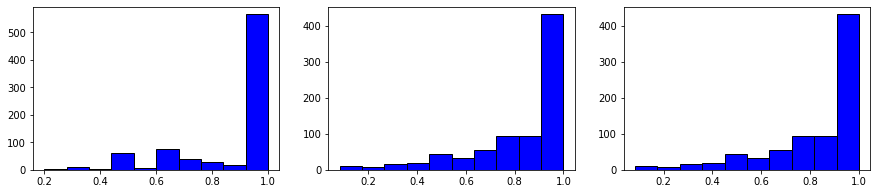

In [224]:
matching_labels_distribution(model_correct_nodes);

Label distribution of nodes classified correctly by GAT

matching labels in 1st hop: tensor(0.9083)
matching labels in 2st hop: tensor(0.8623)
matching labels in 3rd hop: tensor(0.8197)


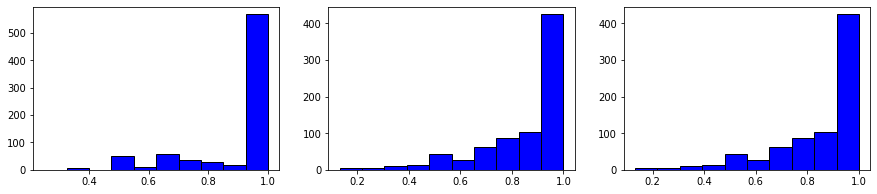

In [225]:
matching_labels_distribution(gat_correct_nodes);

Label distribution of nodes classified correctly by our model but not by GAT

matching labels in 1st hop: tensor(0.6593)
matching labels in 2st hop: tensor(0.4637)
matching labels in 3rd hop: tensor(0.3674)


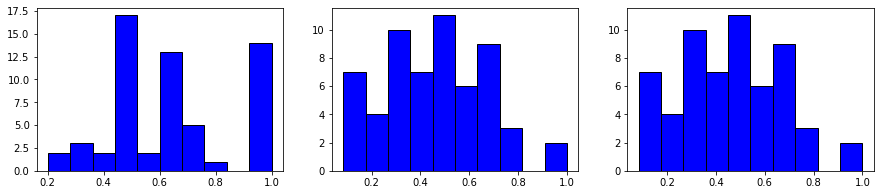

In [226]:
matching_labels_distribution(model_not_gat_correct_nodes);

Label distribution of nodes classified correctly our model and by GAT

matching labels in 1st hop: tensor(0.9122)
matching labels in 2st hop: tensor(0.8687)
matching labels in 3rd hop: tensor(0.8246)


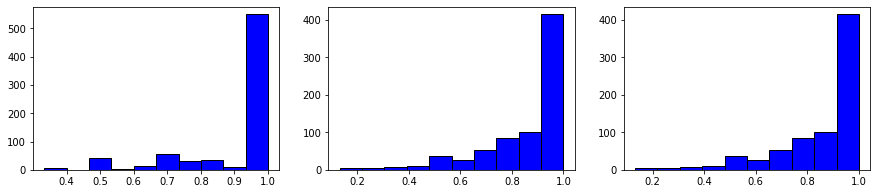

In [227]:
matching_labels_distribution(model_and_gat_correct_nodes);

Label distribution of nodes classified correctly GAT but not by our model

In [ ]:
matching_labels_distribution(gat_not_model_correct_nodes)

Label distribution of nodes classified incorrectly by both GAT and our model

In [ ]:
matching_labels_distribution(gat_and_model_incorrect_nodes)